# Imports:

In [1]:
import os
os.chdir('C:\\Users\\imazeh\\Itzik\\Health_prof\\git_team\\DataScientists')
from Utils.Visualization import box_plot
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats.stats import pearsonr, ttest_ind
from os.path import join, sep
import Teva.config as c
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

# Set some important variables:

In [2]:
valid_users = c.valid_users
watch_acc_base = c.watch_acc_baseline
phone_acc_base = c.phone_acc_baseline
statistics = ['median', 'mean', np.std]
min_val = c.report_values[0]
max_val = c.report_values[-1]

In [3]:
trim_dict = {'TUaG': {'start':2, 'end':2},
             'Sit relaxed': {'start':2, 'end':0},
             'Sit extended': {'start':2, 'end':0},
             'Stand': {'start':2, 'end':0},
             'Walk': {'start':2, 'end':2},
             'Drink': {'start':2, 'end':2},
             'Rotate hands': {'start':2, 'end':0}
            }

# Set working environment:

In [4]:
cloud = False
if cloud:
    data_path = c.cloud_data_path
else:
    data_path = c.data_path

# Read Data:

In [5]:
clinic_assessments_watch_acc_df = pd.read_pickle(c.clinic_assessments_watch_acc_pkl_file_path)
clinic_assessments_watch_acc_df.name = 'clinic_assessments_watch_acc'

clinic_steps_watch_acc_df = pd.read_pickle(c.clinic_steps_watch_acc_pkl_file_path)
clinic_steps_watch_acc_df.name = 'clinic_steps_watch_acc'

home_assessments_watch_acc_df = pd.read_pickle(c.home_assessments_watch_acc_pkl_file_path)
home_assessments_watch_acc_df.name = 'home_assessments_watch_acc'

home_steps_watch_acc_df = pd.read_pickle(c.home_steps_watch_acc_pkl_file_path)
home_steps_watch_acc_df.name = 'home_steps_watch_acc'

home_reminders_watch_acc_df = pd.read_pickle(c.home_reminders_watch_acc_pkl_file_path)
home_reminders_watch_acc_df.name = 'home_reminders_watch_acc'

clinic_steps_phone_acc_df = pd.read_pickle(c.clinic_steps_phone_acc_pkl_file_path)
clinic_steps_phone_acc_df.name = 'clinic_steps_phone_acc'

home_steps_phone_acc_df = pd.read_pickle(c.home_steps_phone_acc_pkl_file_path)
home_steps_phone_acc_df.name = 'home_steps_phone_acc'

In [6]:
def trim_assessment_per_step(assess_df, trim_dict, samples_freq=50):
    sorted_assess_df = assess_df.sort_values(by='timestamp', ascending=True)
    steps_list = assess_df['step_name'].unique()
    trimmed_df = pd.DataFrame()
    for step in steps_list:
        step_df = sorted_assess_df[sorted_assess_df['step_name']==step]
        trim_start_sec = trim_dict[step]['start']
        trim_start_samp = trim_start_sec*samples_freq
        trim_end_sec = trim_dict[step]['end']
        if trim_end_sec != 0:
            trim_end_samp = -(trim_end_sec*samples_freq)
        else:
            trim_end_samp = step_df.shape[0]
        trimmed_step = step_df.iloc[trim_start_samp:trim_end_samp]
        trimmed_df = pd.concat([trimmed_df, trimmed_step])
    return trimmed_df

In [7]:
def trim_entire_df_per_step(df, trim_dict, samsamples_freq=50):
    sorted_df = df.sort_values(by='timestamp', ascending=True)
    assessments_list = df['assessment_id'].unique()
    trimmed_entire_df = pd.DataFrame()
    for assess in assessments_list:
        assess_df = sorted_df[sorted_df['assessment_id']==assess]
        trimmed_assess = trim_assessment_per_step(assess_df, trim_dict)
        trimmed_entire_df = pd.concat([trimmed_entire_df, trimmed_assess])
    return trimmed_entire_df

## Check which users appear in which datasets:

In [8]:
print(sorted(clinic_assessments_watch_acc_df.user_id.unique().astype(int).tolist()))
print(sorted(clinic_steps_watch_acc_df.user_id.unique().astype(int).tolist()))
print(sorted(home_assessments_watch_acc_df.user_id.unique().astype(int).tolist()))
print(sorted(home_steps_watch_acc_df.user_id.unique().astype(int).tolist()))
print(sorted(home_reminders_watch_acc_df.user_id.unique().astype(int).tolist()))
print(sorted(clinic_steps_phone_acc_df.user_id.unique().astype(int).tolist()))
print(sorted(home_steps_phone_acc_df.user_id.unique().astype(int).tolist()))

[8, 25, 45, 51, 57, 63, 74, 82, 94, 108]
[8, 25, 45, 51, 57, 63, 74, 82, 94, 108]
[8, 25, 45, 51, 57, 63, 74, 82, 94, 108]
[8, 25, 45, 51, 57, 63, 74, 82, 94, 108]
[8, 45, 51, 57, 63, 74, 82, 94, 108]
[8, 25, 45, 51, 57, 63, 74, 82, 94, 108]
[8, 25, 45, 51, 57, 63, 74, 82, 94, 108]


## Present reports from the lab, per assessment:

In [7]:
clinic_assessments_watch_acc_df[['user_id', 'assessment_id', 'patient_report_value', 'clinician_report_value']].\
groupby(['user_id', 'assessment_id'], as_index=False).agg('mean').head(15)

user_id  assessment_id  patient_report_value  clinician_report_value
0         8  1490640580656                   1.0                     2.0
1        25  1487605701264                   1.0                     2.0
2        25  1493912424448                   0.0                     2.0
3        45  1490637319938                   2.0                     3.0
4        51  1490284781631                   3.0                     2.0
5        57  1481923232988                   1.0                     2.0
6        63  1493920652116                   0.0                     2.0
7        74  1485546321147                   2.0                     2.0
8        82  1489765988342                   3.0                     4.0
9        94  1493741957038                   3.0                     2.0
10      108  1488396181636                   0.0                     2.0

# Raw accelerometer data analysis:

## Trim all steps according to the trim settings above:

In [9]:
trimmed_clinic_steps_watch_acc = trim_entire_df_per_step(clinic_steps_watch_acc_df, trim_dict)
trimmed_clinic_steps_watch_acc.name = 'trimmed_clinic_steps_watch_acc'

trimmed_clinic_steps_phone_acc = trim_entire_df_per_step(clinic_steps_phone_acc_df, trim_dict)
trimmed_clinic_steps_phone_acc.name = 'trimmed_clinic_steps_phone_acc'

trimmed_home_steps_watch_acc = trim_entire_df_per_step(home_steps_watch_acc_df, trim_dict)
trimmed_home_steps_watch_acc.name = 'trimmed_home_steps_watch_acc'

trimmed_home_steps_phone_acc = trim_entire_df_per_step(home_steps_phone_acc_df, trim_dict)
trimmed_home_steps_phone_acc.name = 'trimmed_home_steps_phone_acc'

## For a given DataFrame (df):
1. Calculate each sample's accelerometer norm
2. Calculate each user's mean norm
3. Calculate each sample's delta between the accelerometer's norm and (1) the device's global baseline and (2) the user's baseline

In [10]:
def enrich_accelerometer_raw_data(df, global_device_baseline):
    # Add the accelerometer's norm:
    df['acc_norm'] = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2)
    # Calculate the accelerometer's baseline for each patient:
    per_patient_norm_mean = df[['user_id', 'acc_norm']].groupby('user_id', as_index=False).agg('mean')
    # Calculate each sample's delta from the global device's baseline:
    df['acc_abs_delta_global'] = abs(df['acc_norm']-watch_acc_base)
    # Calculate each sample's delta from the patient's baseline:
    df_with_baseline = df.merge(right=per_patient_norm_mean,
                                how='inner',
                                on='user_id',
                                suffixes=['', '_user_mean'])
    df_with_baseline['acc_abs_delta_user_bl'] = abs(df_with_baseline['acc_norm']-df_with_baseline['acc_norm_user_mean'])
    return df_with_baseline

In [11]:
clinic_watch_acc_with_deltas = enrich_accelerometer_raw_data(trimmed_clinic_steps_watch_acc, watch_acc_base)
clinic_phone_acc_with_deltas = enrich_accelerometer_raw_data(trimmed_clinic_steps_phone_acc, phone_acc_base)
home_watch_acc_with_deltas = enrich_accelerometer_raw_data(trimmed_home_steps_watch_acc, watch_acc_base)
home_phone_acc_with_deltas = enrich_accelerometer_raw_data(trimmed_home_steps_phone_acc, phone_acc_base)

### Inspect the per patient distribution of the accelerometer norm, for step "Sit relaxed":

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025502BC7A20>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000025506FADF28>]], dtype=object)

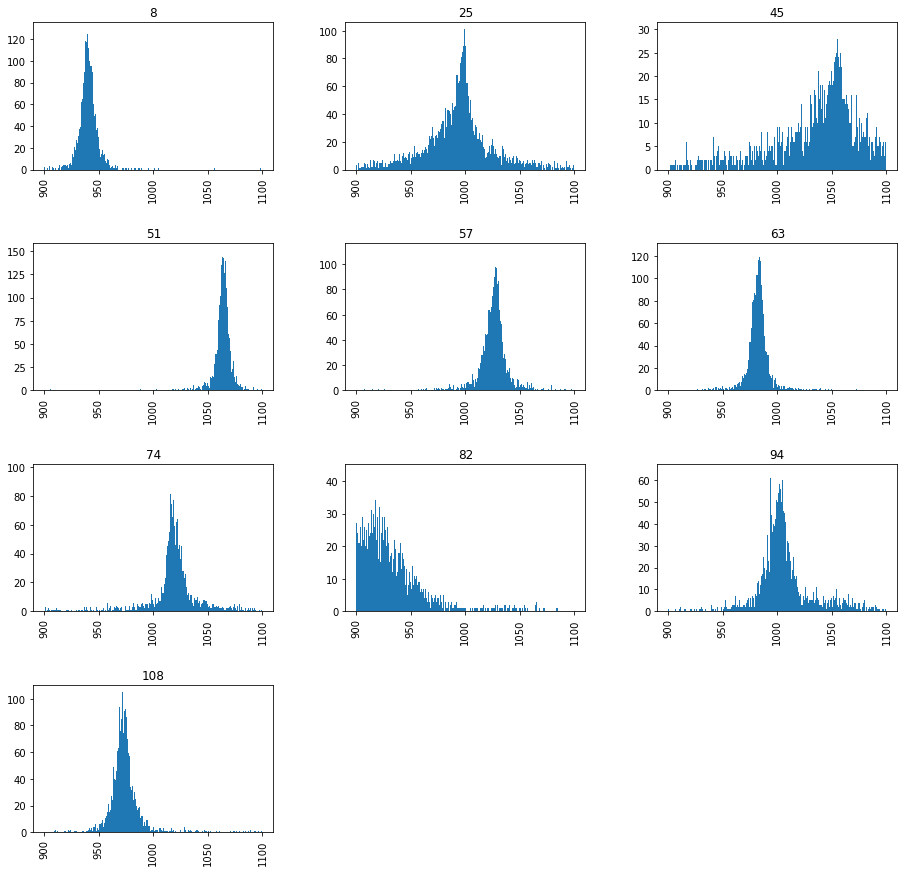

In [213]:
clinic_steps_watch_sit = clinic_steps_watch_acc_df[['user_id', 'acc_norm']]\
                           [clinic_steps_watch_acc_df.step_name=='Sit relaxed']
clinic_steps_watch_sit['acc_norm'].hist(by=clinic_steps_watch_sit['user_id'], figsize=(15,15),
                                           bins=700, range=(900, 1100))

### And for the entire data (without specifying a step):

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000253A39723C8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000253A745AE10>]], dtype=object)

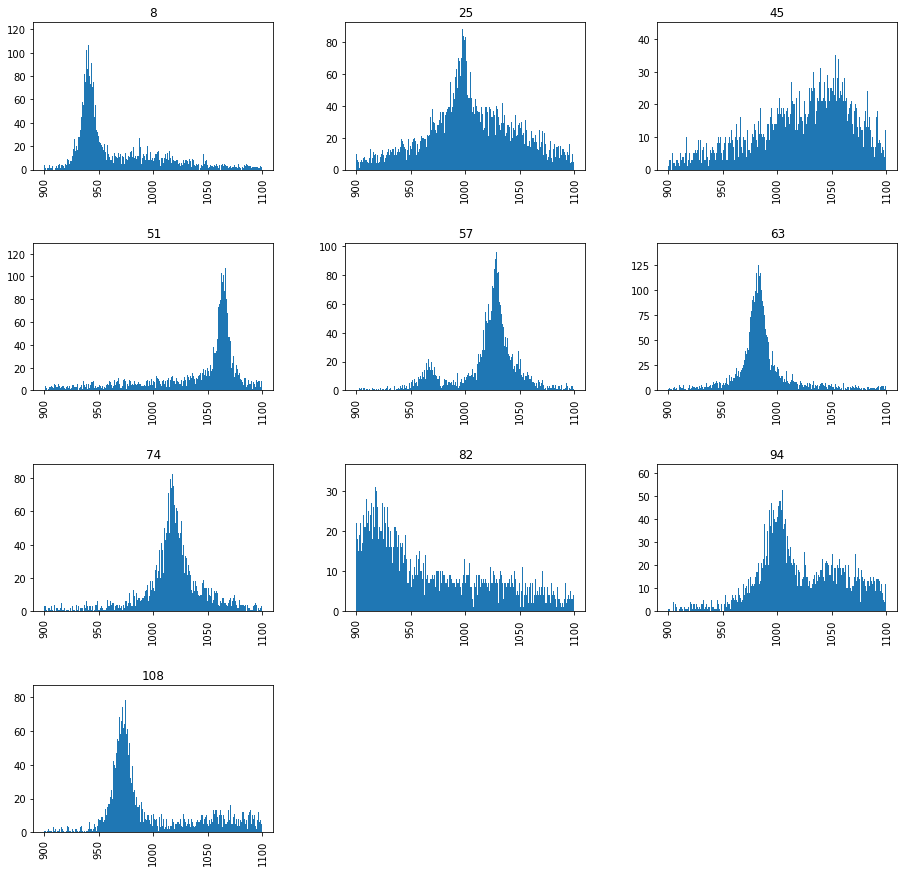

In [132]:
clinic_steps_watch_acc_df['acc_norm'].hist(by=clinic_steps_watch_acc_df['user_id'], figsize=(15,15),
                                           bins=1000, range=(900, 1100))

### Inspect the per patient distribution of the (per-step) accelerometer mean, over time, for step "Sit relaxed":

In [153]:
home_steps_watch_acc_df.sort_values(by='timestamp', ascending=True, inplace=True)
home_steps_watch_mean_norm = home_steps_watch_acc_df[['user_id', 'timestamp', 'assessment_id', 'step_name', 'acc_norm']]\
                             [home_steps_watch_acc_df.step_name=='Sit relaxed']\
                             .groupby(['user_id', 'assessment_id', 'step_name'], as_index=False).agg('mean')

Patient: 8


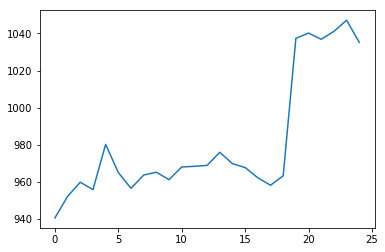

Patient: 25


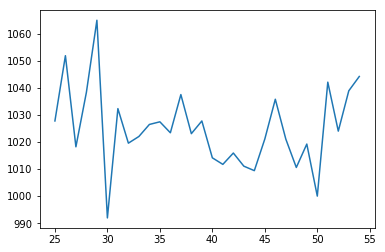

Patient: 45


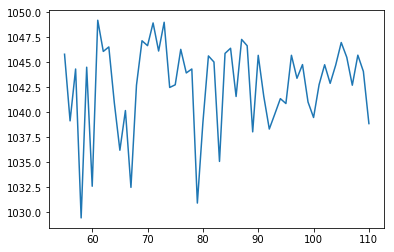

Patient: 51


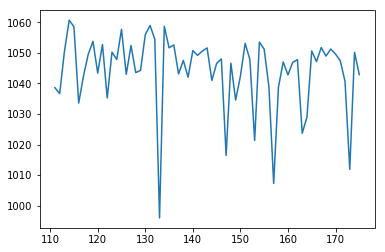

Patient: 57


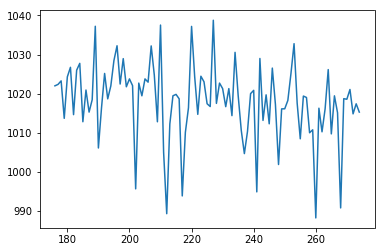

Patient: 63


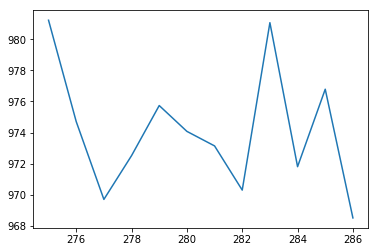

Patient: 74


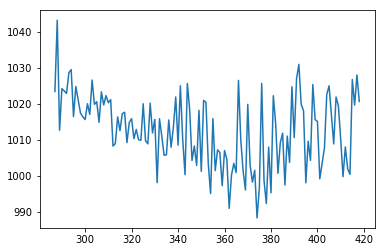

Patient: 82


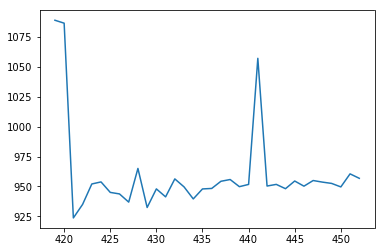

Patient: 94


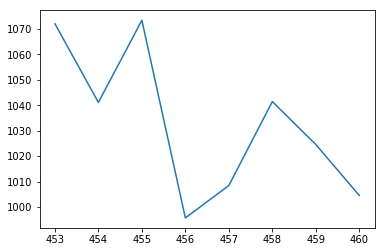

Patient: 108


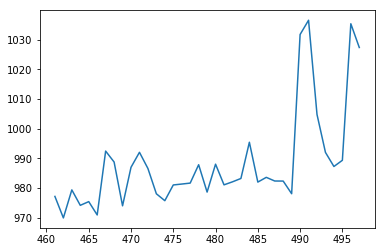

In [154]:
for u in home_steps_watch_mean_norm.user_id.unique():
    print('Patient: %s' % (u))
    plt.plot(home_steps_watch_mean_norm['acc_norm'][home_steps_watch_mean_norm.user_id==u])
    plt.show()
    plt.close()

## Show box-plots for per-assessment activity level vs. reported chorea:

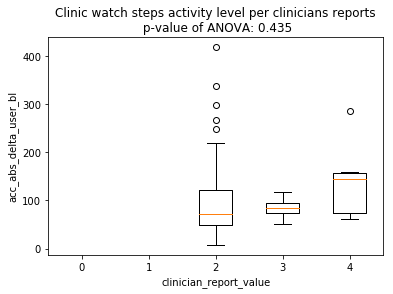

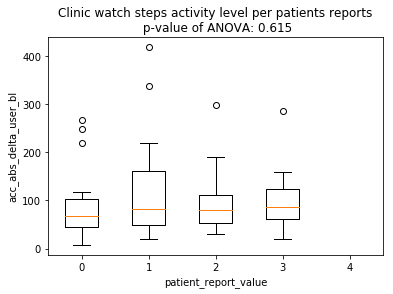

In [39]:
clinic_watch_acc_per_step_al = clinic_watch_acc_with_deltas[['assessment_id', 'step_name', 'patient_report_value',
                                                             'clinician_report_value', 'acc_abs_delta_user_bl']].\
                               groupby(['assessment_id', 'step_name'], as_index=False).agg('mean')

boxes_vals = [np.asarray(clinic_watch_acc_per_step_al['acc_abs_delta_user_bl']\
              [clinic_watch_acc_per_step_al['clinician_report_value'] == x]) for x in clinic_watch_acc_per_step_al['clinician_report_value'].unique()]
f, p = stats.f_oneway(boxes_vals[0], boxes_vals[1], boxes_vals[2])
box_plot.create_box_plot(clinic_watch_acc_per_step_al, 'clinician_report_value', 'acc_abs_delta_user_bl',
                         all_possible_x_vals=c.report_values,
                         plt_title='Clinic watch steps activity level per clinicians reports\n p-value of ANOVA: %.3f' % (p))

boxes_vals = [np.asarray(clinic_watch_acc_per_step_al['acc_abs_delta_user_bl']\
              [clinic_watch_acc_per_step_al['patient_report_value'] == x]) for x in clinic_watch_acc_per_step_al['patient_report_value'].unique()]
f, p = stats.f_oneway(boxes_vals[0], boxes_vals[1], boxes_vals[2], boxes_vals[3])
box_plot.create_box_plot(clinic_watch_acc_per_step_al, 'patient_report_value', 'acc_abs_delta_user_bl',
                         all_possible_x_vals=c.report_values,
                         plt_title='Clinic watch steps activity level per patients reports\n p-value of ANOVA: %.3f' % (p))

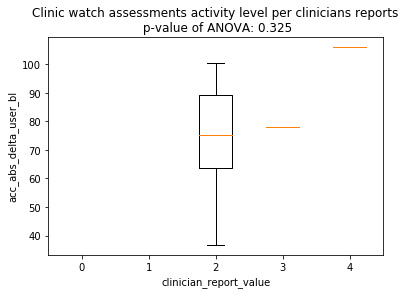

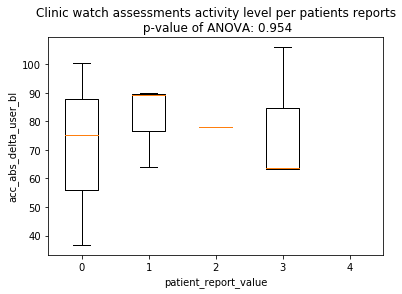

In [40]:
clinic_watch_acc_per_assess_al = clinic_watch_acc_with_deltas[['assessment_id', 'patient_report_value',
                                                             'clinician_report_value', 'acc_abs_delta_user_bl']].\
                               groupby(['assessment_id'], as_index=False).agg('mean')

boxes_vals = [np.asarray(clinic_watch_acc_per_assess_al['acc_abs_delta_user_bl']\
              [clinic_watch_acc_per_assess_al['clinician_report_value'] == x]) for x in clinic_watch_acc_per_assess_al['clinician_report_value'].unique()]
f, p = stats.f_oneway(boxes_vals[0], boxes_vals[1], boxes_vals[2])
box_plot.create_box_plot(clinic_watch_acc_per_assess_al, 'clinician_report_value', 'acc_abs_delta_user_bl',
                         all_possible_x_vals=c.report_values,
                         plt_title='Clinic watch assessments activity level per clinicians reports\n p-value of ANOVA: %.3f' % (p))

boxes_vals = [np.asarray(clinic_watch_acc_per_assess_al['acc_abs_delta_user_bl']\
              [clinic_watch_acc_per_assess_al['patient_report_value'] == x]) for x in clinic_watch_acc_per_assess_al['patient_report_value'].unique()]
f, p = stats.f_oneway(boxes_vals[0], boxes_vals[1], boxes_vals[2], boxes_vals[3])
box_plot.create_box_plot(clinic_watch_acc_per_assess_al, 'patient_report_value', 'acc_abs_delta_user_bl',
                         all_possible_x_vals=c.report_values,
                         plt_title='Clinic watch assessments activity level per patients reports\n p-value of ANOVA: %.3f' % (p))

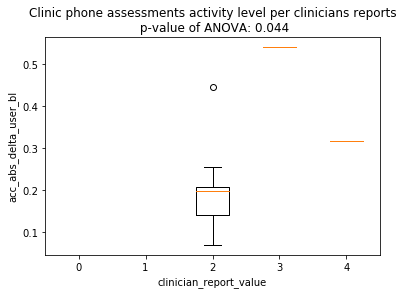

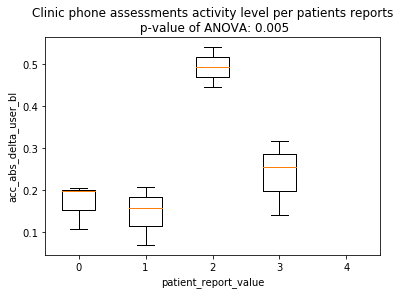

In [41]:
clinic_phone_acc_per_assess_al = clinic_phone_acc_with_deltas[['assessment_id', 'patient_report_value',
                                                             'clinician_report_value', 'acc_abs_delta_user_bl']].\
                               groupby(['assessment_id'], as_index=False).agg('mean')

boxes_vals = [np.asarray(clinic_phone_acc_per_assess_al['acc_abs_delta_user_bl']\
              [clinic_phone_acc_per_assess_al['clinician_report_value'] == x]) for x in clinic_phone_acc_per_assess_al['clinician_report_value'].unique()]
f, p = stats.f_oneway(boxes_vals[0], boxes_vals[1], boxes_vals[2])
box_plot.create_box_plot(clinic_phone_acc_per_assess_al, 'clinician_report_value', 'acc_abs_delta_user_bl',
                         all_possible_x_vals=c.report_values,
                         plt_title='Clinic phone assessments activity level per clinicians reports\n p-value of ANOVA: %.3f' % (p))

boxes_vals = [np.asarray(clinic_phone_acc_per_assess_al['acc_abs_delta_user_bl']\
              [clinic_phone_acc_per_assess_al['patient_report_value'] == x]) for x in clinic_phone_acc_per_assess_al['patient_report_value'].unique()]
f, p = stats.f_oneway(boxes_vals[0], boxes_vals[1], boxes_vals[2], boxes_vals[3])
box_plot.create_box_plot(clinic_phone_acc_per_assess_al, 'patient_report_value', 'acc_abs_delta_user_bl',
                         all_possible_x_vals=c.report_values,
                         plt_title='Clinic phone assessments activity level per patients reports\n p-value of ANOVA: %.3f' % (p))

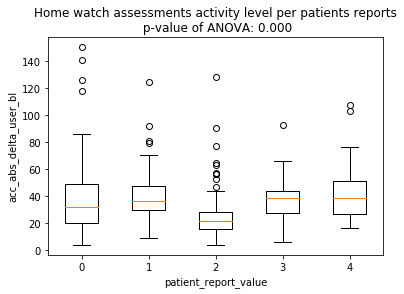

In [42]:
home_watch_acc_per_assess_al = home_watch_acc_with_deltas[['assessment_id', 'patient_report_value',
                                                             'acc_abs_delta_user_bl']].\
                               groupby(['assessment_id'], as_index=False).agg('mean')

boxes_vals = [np.asarray(home_watch_acc_per_assess_al['acc_abs_delta_user_bl']\
              [home_watch_acc_per_assess_al['patient_report_value'] == x]) for x in home_watch_acc_per_assess_al['patient_report_value'].unique()]
f, p = stats.f_oneway(boxes_vals[0], boxes_vals[1], boxes_vals[2], boxes_vals[3], boxes_vals[4])
box_plot.create_box_plot(home_watch_acc_per_assess_al, 'patient_report_value', 'acc_abs_delta_user_bl',
                         all_possible_x_vals=c.report_values,
                         plt_title='Home watch assessments activity level per patients reports\n p-value of ANOVA: %.3f' % (p))

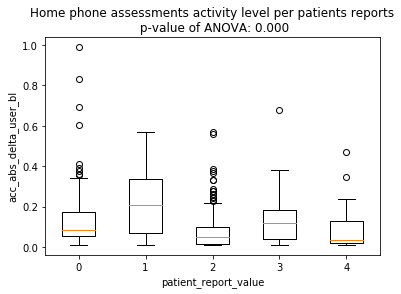

In [43]:
home_phone_acc_per_assess_al = home_phone_acc_with_deltas[['assessment_id', 'patient_report_value',
                                                             'acc_abs_delta_user_bl']].\
                               groupby(['assessment_id'], as_index=False).agg('mean')

boxes_vals = [np.asarray(home_phone_acc_per_assess_al['acc_abs_delta_user_bl']\
              [home_phone_acc_per_assess_al['patient_report_value'] == x]) for x in home_phone_acc_per_assess_al['patient_report_value'].unique()]
f, p = stats.f_oneway(boxes_vals[0], boxes_vals[1], boxes_vals[2], boxes_vals[3], boxes_vals[4])
box_plot.create_box_plot(home_phone_acc_per_assess_al, 'patient_report_value', 'acc_abs_delta_user_bl',
                         all_possible_x_vals=c.report_values,
                         plt_title='Home phone assessments activity level per patients reports\n p-value of ANOVA: %.3f' % (p))

## Box-plots, older version:

In [191]:
static_steps_clinic = ['Sit extended', 'Sit relaxed', 'Stand']
static_steps_home = ['Sit relaxed', 'Stand']

## Clinic steps - acc delta from user's baseline, with and without trim - PATIENTS REPORTS:

-----------------------------------------------------------------------------------------
Step: Sit extended in clinic_steps_watch_acc_with_user_baseline
p-value of ANOVA: 0.158


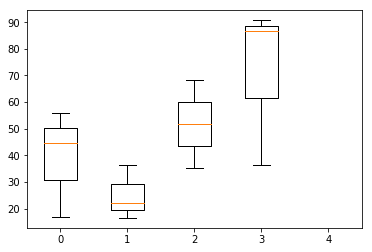

Step: Sit relaxed in clinic_steps_watch_acc_with_user_baseline
p-value of ANOVA: 0.195


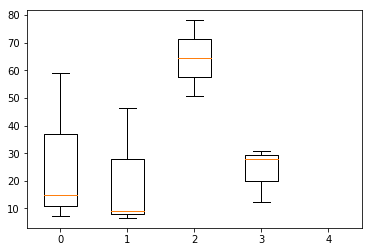

Step: Stand in clinic_steps_watch_acc_with_user_baseline
p-value of ANOVA: 0.885


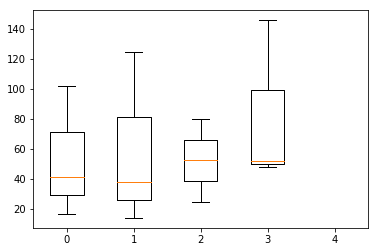

-----------------------------------------------------------------------------------------
Step: Sit extended in trimmed_clinic_steps_watch_acc_with_user_baseline
p-value of ANOVA: 0.152


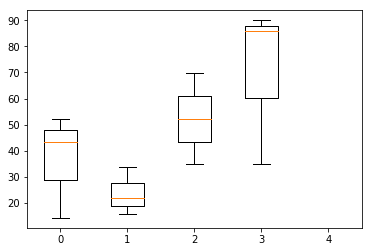

Step: Sit relaxed in trimmed_clinic_steps_watch_acc_with_user_baseline
p-value of ANOVA: 0.195


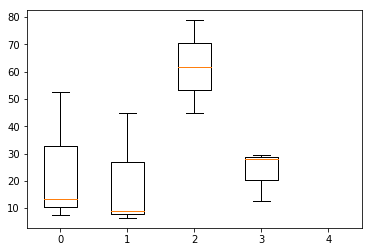

Step: Stand in trimmed_clinic_steps_watch_acc_with_user_baseline
p-value of ANOVA: 0.783


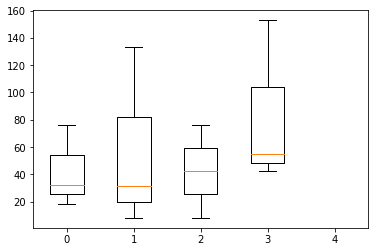

In [209]:
for df in [clinic_steps_watch_acc_w_base, trimmed_clinic_steps_watch_acc_w_base]:
    print('-----------------------------------------------------------------------------------------')
    for step in static_steps_clinic:
        step_df = df[df['step_name']==step]
        agg = step_df[['assessment_id', 'step_name', 'acc_abs_delta_user_bl', 'patient_report_value']]\
              .groupby(['assessment_id', 'step_name'], as_index=False).agg('mean')
        boxes_vals = [np.asarray(agg['acc_abs_delta_user_bl'][agg['patient_report_value'] == x]) for x in discrete_report_values]
        f, p = stats.f_oneway(boxes_vals[0], boxes_vals[1], boxes_vals[2], boxes_vals[3])
        print('Step: %s in %s' % (step, df.name))
        print('p-value of ANOVA: %.3f' % (p))
        plt.boxplot(boxes_vals)
        plt.xticks(range(min_val+1, max_val+2), range(5))
        plt.show()
        plt.close()

## Clinic steps - acc delta from user's baseline, with and without trim - CLINICIANS REPORTS:

----------------------------------------------------------------------
Step: Sit extended in clinic_steps_watch_acc_with_user_baseline
p-value of ANOVA: 0.155


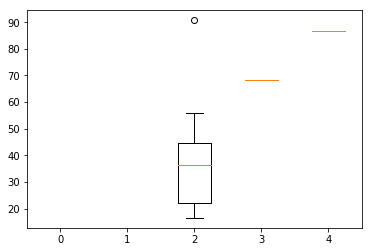

Step: Sit relaxed in clinic_steps_watch_acc_with_user_baseline
p-value of ANOVA: 0.119


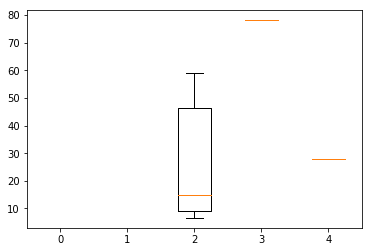

Step: Stand in clinic_steps_watch_acc_with_user_baseline
p-value of ANOVA: 0.112


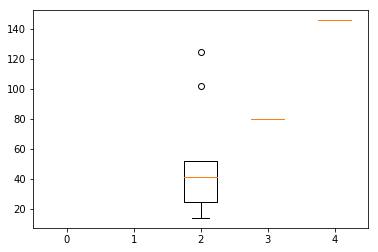

----------------------------------------------------------------------
Step: Sit extended in trimmed_clinic_steps_watch_acc_with_user_baseline
p-value of ANOVA: 0.139


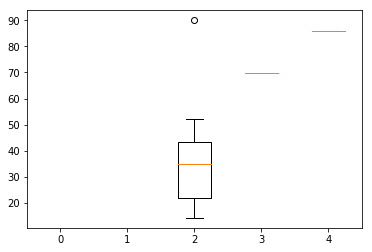

Step: Sit relaxed in trimmed_clinic_steps_watch_acc_with_user_baseline
p-value of ANOVA: 0.068


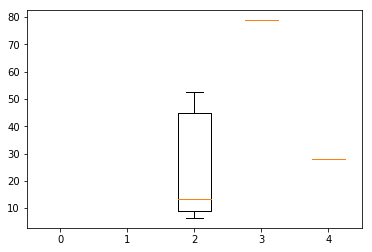

Step: Stand in trimmed_clinic_steps_watch_acc_with_user_baseline
p-value of ANOVA: 0.082


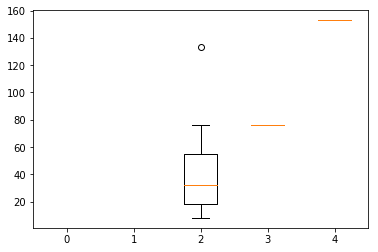

In [202]:
for df in [clinic_steps_watch_acc_w_base, trimmed_clinic_steps_watch_acc_w_base]:
    print('-----------------------------------------------------------------------------------------')
    for step in static_steps_clinic:
        step_df = df[df['step_name']==step]
        agg = step_df[['assessment_id', 'step_name', 'acc_abs_delta_user_bl', 'clinician_report_value']]\
              .groupby(['assessment_id', 'step_name'], as_index=False).agg('mean')
        boxes_vals = [np.asarray(agg['acc_abs_delta_user_bl'][agg['clinician_report_value'] == x]) for x in discrete_report_values]
        f, p = stats.f_oneway(boxes_vals[2], boxes_vals[3], boxes_vals[4])
        print('Step: %s in %s' % (step, df.name))
        print('p-value of ANOVA: %.3f' % (p))
        plt.boxplot(boxes_vals)
        plt.xticks(range(min_val+1, max_val+2), range(5))
        plt.show()
        plt.close()

## Clinic steps - acc delta from general baseline, with and without trim:

-----------------------------------------------------------------------------------------
Step: Sit extended in clinic_steps_watch_acc
p-value of ANOVA: 0.354


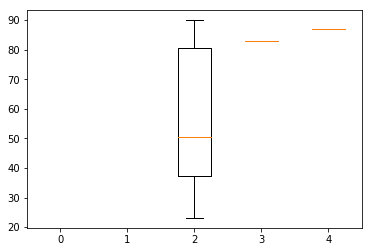

Step: Sit relaxed in clinic_steps_watch_acc
p-value of ANOVA: 0.031


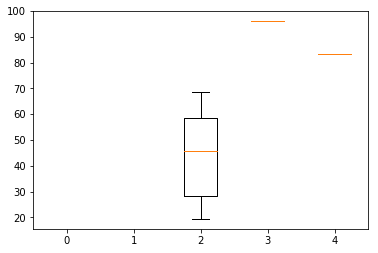

Step: Stand in clinic_steps_watch_acc
p-value of ANOVA: 0.141


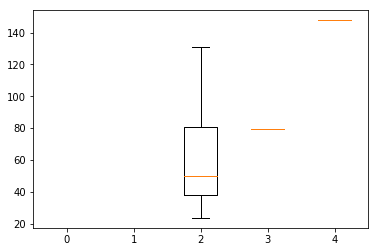

-----------------------------------------------------------------------------------------
Step: Sit extended in trimmed_clinic_steps_watch_acc
p-value of ANOVA: 0.323


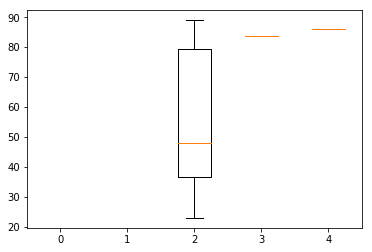

Step: Sit relaxed in trimmed_clinic_steps_watch_acc
p-value of ANOVA: 0.020


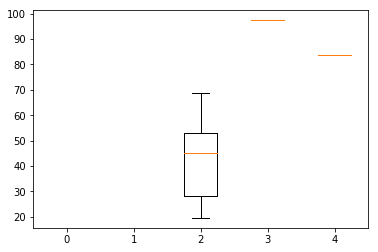

Step: Stand in trimmed_clinic_steps_watch_acc
p-value of ANOVA: 0.112


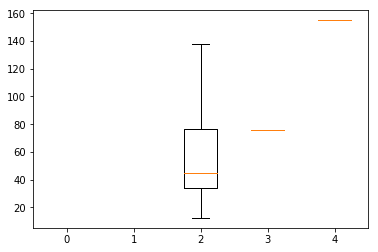

In [204]:
for df in [clinic_steps_watch_acc_df, trimmed_clinic_steps_watch_acc]:
    print('-----------------------------------------------------------------------------------------')
    for step in static_steps_clinic:
        step_df = df[df['step_name']==step]
        agg = step_df[['assessment_id', 'step_name', 'acc_abs_delta', 'clinician_report_value']]\
              .groupby(['assessment_id', 'step_name'], as_index=False).agg('mean')
        boxes_vals = [np.asarray(agg['acc_abs_delta'][agg['clinician_report_value'] == x]) for x in discrete_report_values]
        f, p = stats.f_oneway(boxes_vals[2], boxes_vals[3], boxes_vals[4])
        print('Step: %s in %s' % (step, df.name))
        print('p-value of ANOVA: %.3f' % (p))
        plt.boxplot(boxes_vals)
        plt.xticks(range(min_val+1, max_val+2), range(5))
        plt.show()
        plt.close()

## Home steps - acc delta from user's baseline, with and without trim:

-----------------------------------------------------------------------------------------
Step: Sit relaxed in home_steps_watch_acc_with_user_baseline
p-value of ANOVA: 0.000


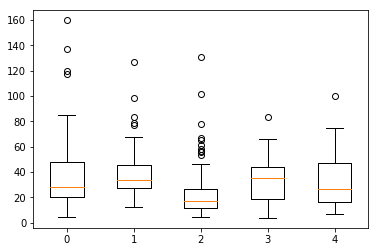

Step: Stand in home_steps_watch_acc_with_user_baseline
p-value of ANOVA: 0.000


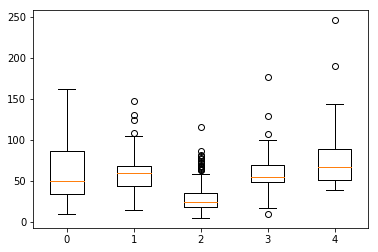

-----------------------------------------------------------------------------------------
Step: Sit relaxed in trimmed_home_steps_watch_acc_with_user_baseline
p-value of ANOVA: 0.000


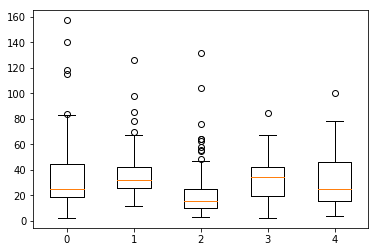

Step: Stand in trimmed_home_steps_watch_acc_with_user_baseline
p-value of ANOVA: 0.000


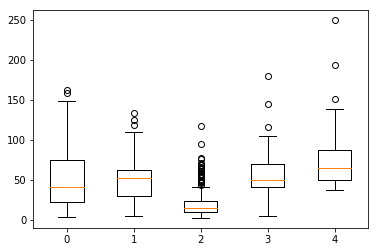

In [205]:
for df in [home_steps_watch_acc_w_base, trimmed_home_steps_watch_acc_w_base]:
    print('-----------------------------------------------------------------------------------------')
    for step in static_steps_home:
        step_df = df[df['step_name']==step]
        agg = step_df[['assessment_id', 'step_name', 'acc_abs_delta_user_bl', 'patient_report_value']]\
              .groupby(['assessment_id', 'step_name'], as_index=False).agg('mean')
        boxes_vals = [np.asarray(agg['acc_abs_delta_user_bl'][agg['patient_report_value'] == x]) for x in discrete_report_values]
        f, p = stats.f_oneway(boxes_vals[0], boxes_vals[1], boxes_vals[2], boxes_vals[3], boxes_vals[4])
        print('Step: %s in %s' % (step, df.name))
        print('p-value of ANOVA: %.3f' % (p))
        plt.boxplot(boxes_vals)
        plt.xticks(range(min_val+1, max_val+2), range(5))
        plt.show()
        plt.close()

## Home steps - acc delta from general baseline, with and without trim:

-----------------------------------------------------------------------------------------
Step: Sit relaxed in home_steps_watch_acc
p-value of ANOVA: 0.000


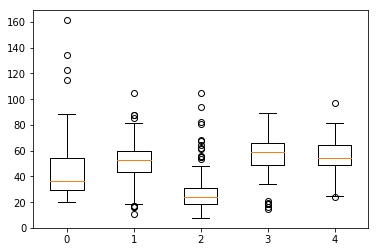

Step: Stand in home_steps_watch_acc
p-value of ANOVA: 0.000


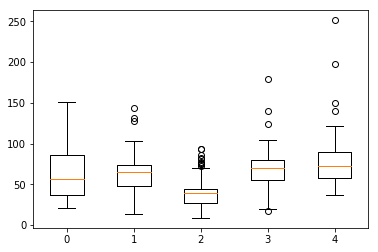

-----------------------------------------------------------------------------------------
Step: Sit relaxed in trimmed_home_steps_watch_acc
p-value of ANOVA: 0.000


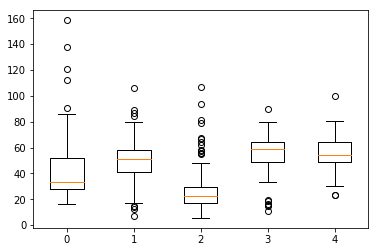

Step: Stand in trimmed_home_steps_watch_acc
p-value of ANOVA: 0.000


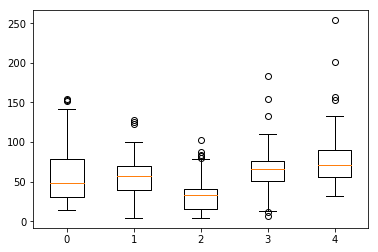

In [206]:
for df in [home_steps_watch_acc_df, trimmed_home_steps_watch_acc]:
    print('-----------------------------------------------------------------------------------------')
    for step in static_steps_home:
        step_df = df[df['step_name']==step]
        agg = step_df[['assessment_id', 'step_name', 'acc_abs_delta', 'patient_report_value']]\
              .groupby(['assessment_id', 'step_name'], as_index=False).agg('mean')
        boxes_vals = [np.asarray(agg['acc_abs_delta'][agg['patient_report_value'] == x]) for x in discrete_report_values]
        f, p = stats.f_oneway(boxes_vals[0], boxes_vals[1], boxes_vals[2], boxes_vals[3], boxes_vals[4])
        print('Step: %s in %s' % (step, df.name))
        print('p-value of ANOVA: %.3f' % (p))
        plt.boxplot(boxes_vals)
        plt.xticks(range(min_val+1, max_val+2), range(5))
        plt.show()
        plt.close()

## Clinic Raw Data Exploration:

In [62]:
def plot_assessment_with_steps(df, sensor, clinic=True):
    if sensor=='watch':
        ylim = 2000
        y_label_delta = 40
    elif sensor=='phone':
        ylim = 15
        y_label_delta = 0.5
    sorted_df = df.sort_values(by='timestamp', ascending=True)
    assessments = sorted_df['assessment_id'].unique()
    for assess in assessments:
        assess_df = sorted_df[sorted_df['assessment_id']==assess].copy()
        assess_df.reset_index(inplace=True)
        
        patient = assess_df['user_id'].unique()[0]
        assessment = assess_df['assessment_id'].unique()[0]
        print('\n\nuser: %s, assessment: %s' % (patient, assessment))
        patient_report = assess_df['patient_report_value'].unique()[0]
        if clinic:
            clinician_report = assess_df['clinician_report_value'].unique()[0]
            print('patient report: %.0f, clinician report: %.0f' % (patient_report, clinician_report))
        else:
            print('patient report: %.0f' % (patient_report))
        
        steps_indxs = dict()

        first_indx_df = assess_df[['assessment_id', 'step_name']].drop_duplicates(keep='first')
        last_indx_df = assess_df[['assessment_id', 'step_name']].drop_duplicates(keep='last')
        for index, row in first_indx_df.iterrows():
            step = row['step_name']
            first_index = index
            last_index = last_indx_df[last_indx_df['step_name']==step].index
            if step not in steps_indxs:
                steps_indxs[step] = (first_index, last_index[0])

        norm_values = assess_df[['assessment_id', 'acc_abs_delta_user_bl']]
        norm = np.mean(norm_values['acc_abs_delta_user_bl'])
        print("Norm's mean delta from baseline: %.2f" % (norm))

        signal = assess_df[['x', 'y', 'z']]
        signal = np.asarray(signal)
        plt.figure(figsize=(20,5))
        plt.plot(signal)
        plt.ylim(-ylim, ylim)
        plt.xticks(range(0, signal.shape[0], 500), range(0, int(signal.shape[0]/50), 10))
        for step in steps_indxs:
            step_start = int(steps_indxs[step][0])
            step_end = int(steps_indxs[step][1])
#             step_len = int(step_end-step_start)
#             text_len = len(step)
#             label = "|"+"-"*int((step_len-text_len)/2)+step+"-"*int((step_len-text_len)/2)+"|"
            plt.text(step_start, ylim+y_label_delta, '|', fontsize=25)
            plt.text(step_start+100, ylim+y_label_delta, step, fontsize=9)
        plt.show()
        plt.close()



user: 57, assessment: 1481923232988
patient report: 1, clinician report: 2
Norm's mean delta from baseline: 89.32


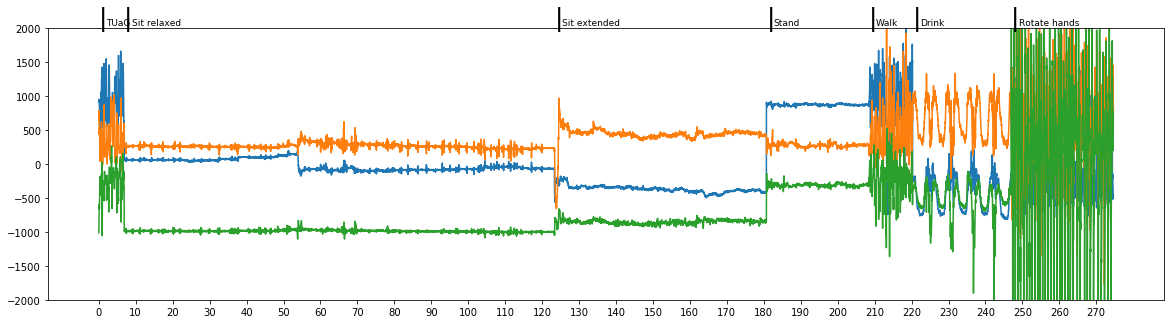



user: 74, assessment: 1485546321147
patient report: 2, clinician report: 2
Norm's mean delta from baseline: 78.21


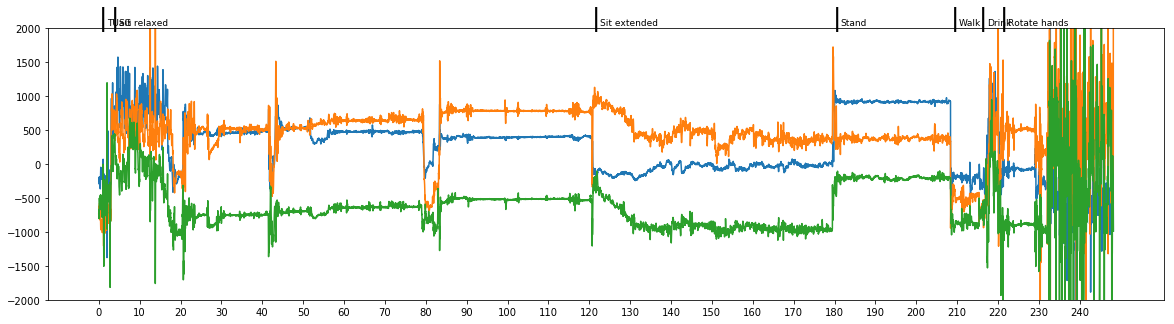



user: 25, assessment: 1487605701264
patient report: 1, clinician report: 2
Norm's mean delta from baseline: 90.09


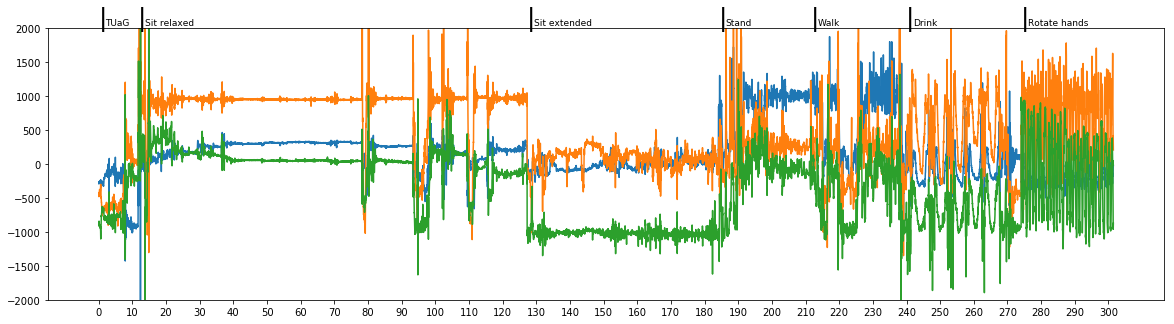



user: 108, assessment: 1488396181636
patient report: 0, clinician report: 2
Norm's mean delta from baseline: 75.39


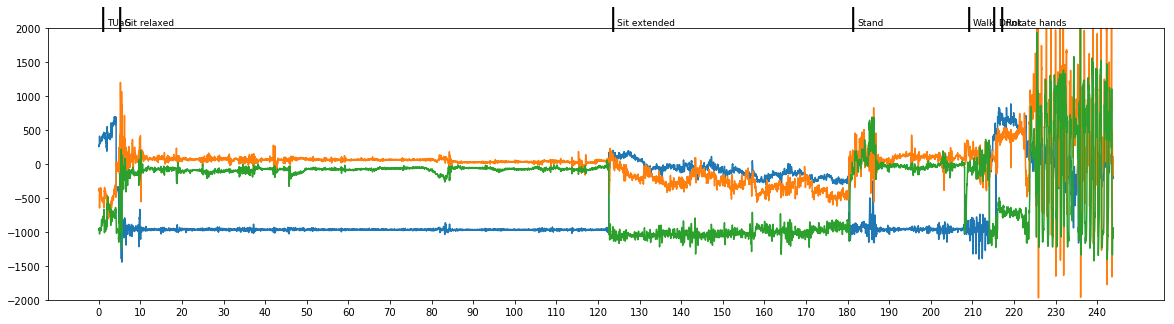



user: 82, assessment: 1489765988342
patient report: 3, clinician report: 4
Norm's mean delta from baseline: 105.98


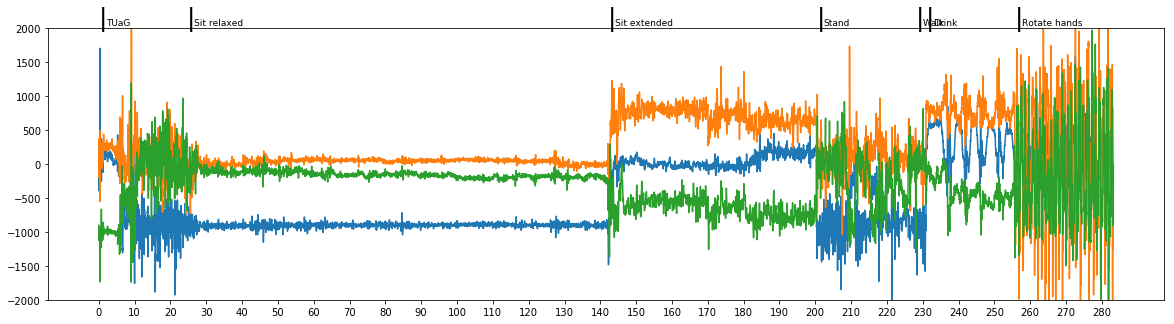



user: 51, assessment: 1490284781631
patient report: 3, clinician report: 2
Norm's mean delta from baseline: 63.27


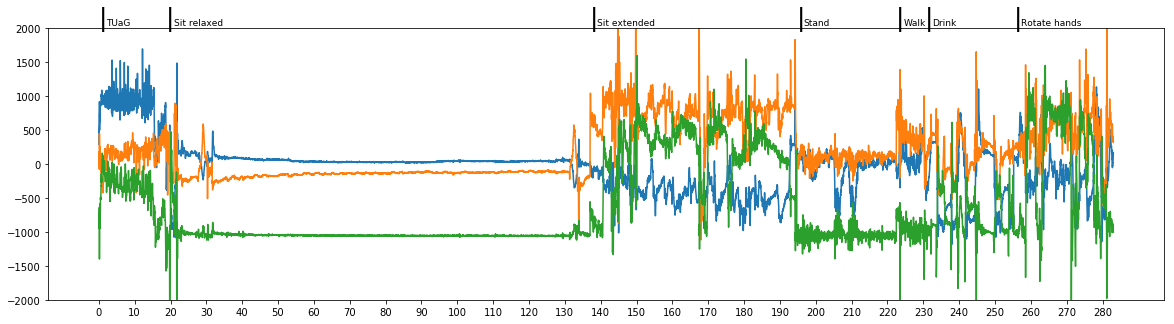



user: 45, assessment: 1490637319938
patient report: 2, clinician report: 3
Norm's mean delta from baseline: 77.95


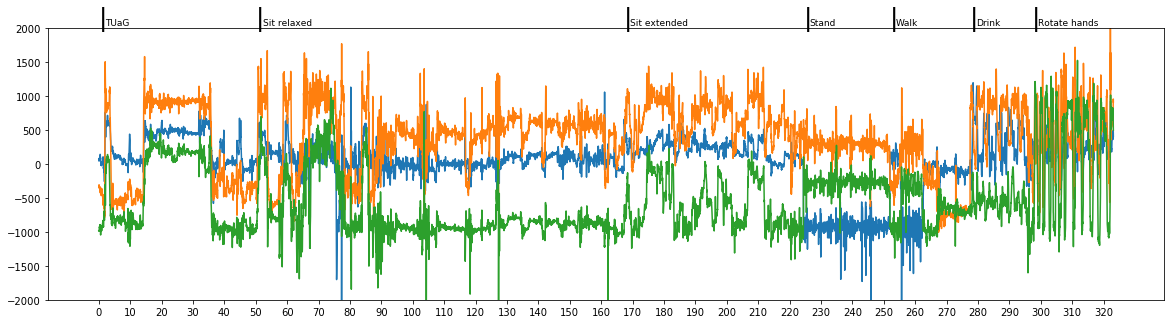



user: 8, assessment: 1490640580656
patient report: 1, clinician report: 2
Norm's mean delta from baseline: 64.18


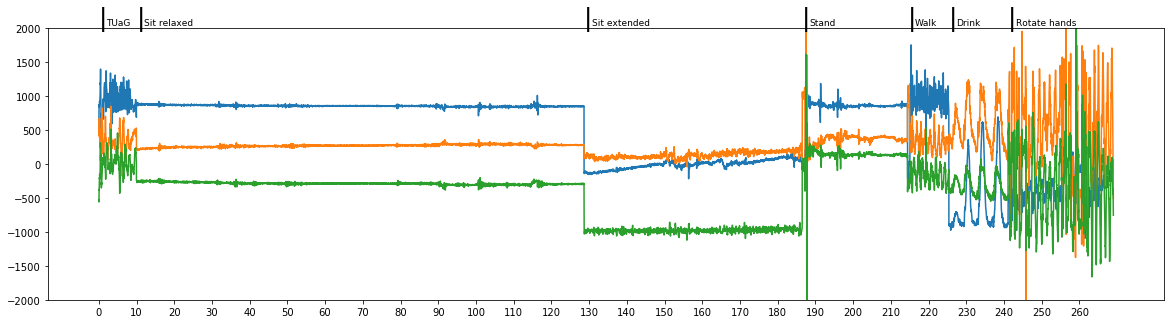



user: 94, assessment: 1493741957038
patient report: 3, clinician report: 2
Norm's mean delta from baseline: 63.55


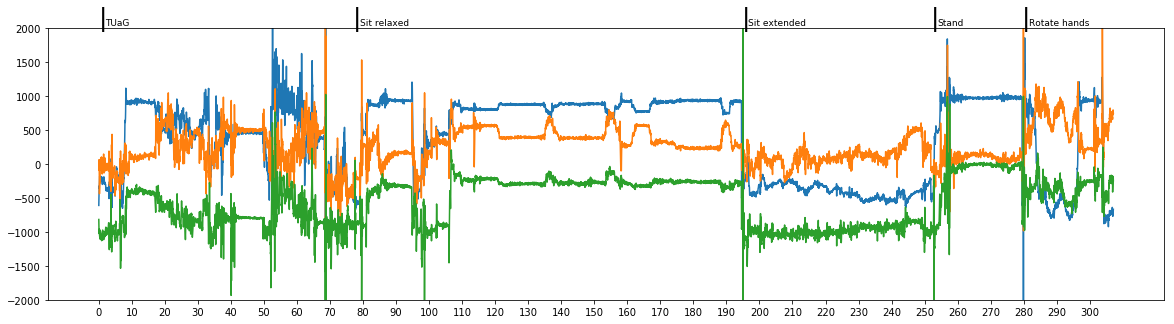



user: 25, assessment: 1493912424448
patient report: 0, clinician report: 2
Norm's mean delta from baseline: 100.61


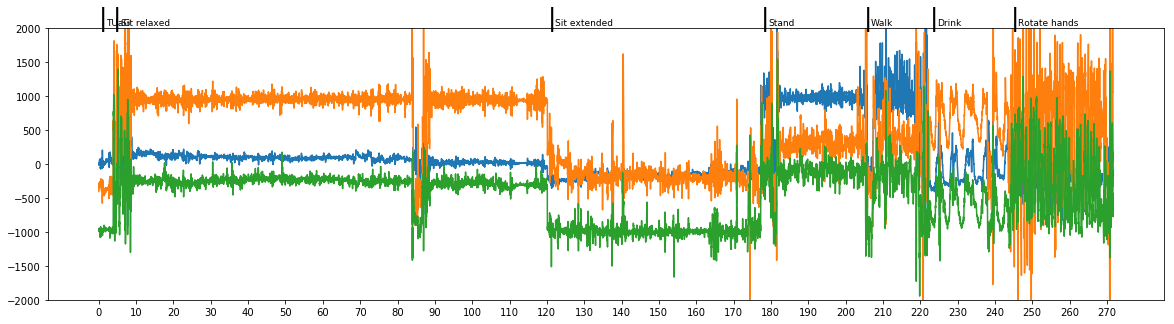



user: 63, assessment: 1493920652116
patient report: 0, clinician report: 2
Norm's mean delta from baseline: 36.68


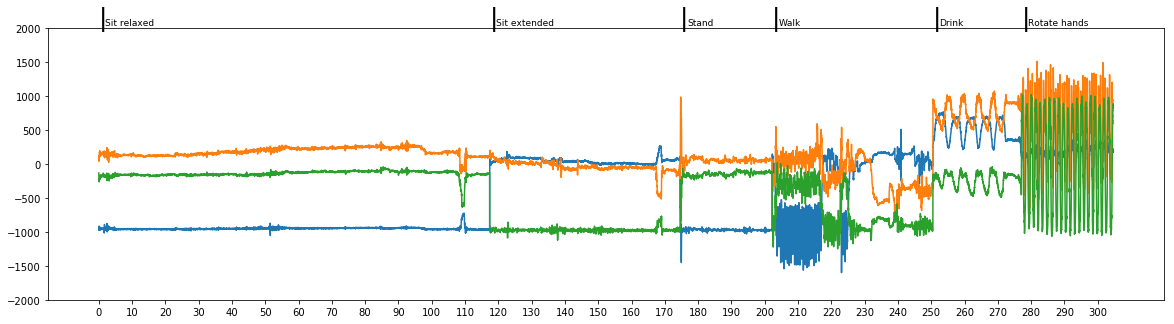

In [63]:
plot_assessment_with_steps(clinic_watch_acc_with_deltas, 'watch')



user: 57, assessment: 1481923232988
patient report: 1, clinician report: 2
Norm's mean delta from baseline: 0.07


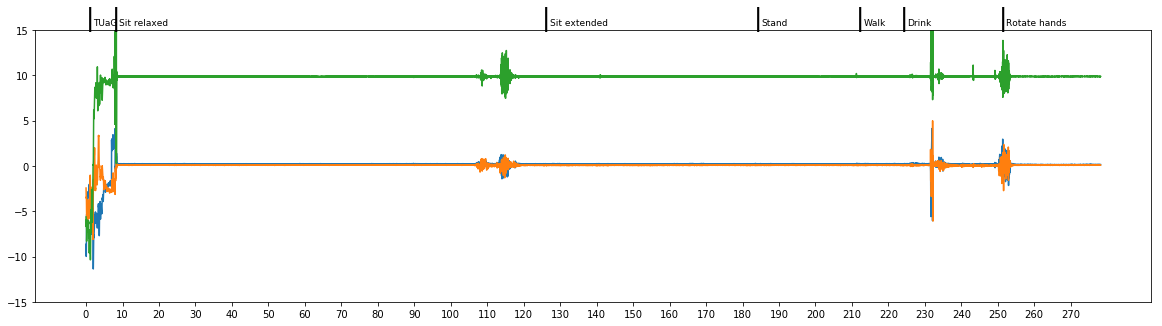



user: 74, assessment: 1485546321147
patient report: 2, clinician report: 2
Norm's mean delta from baseline: 0.45


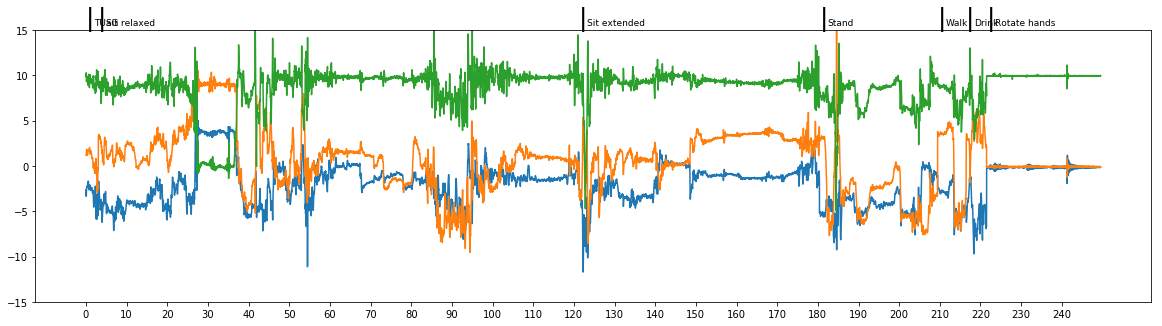



user: 25, assessment: 1487605701264
patient report: 1, clinician report: 2
Norm's mean delta from baseline: 0.21


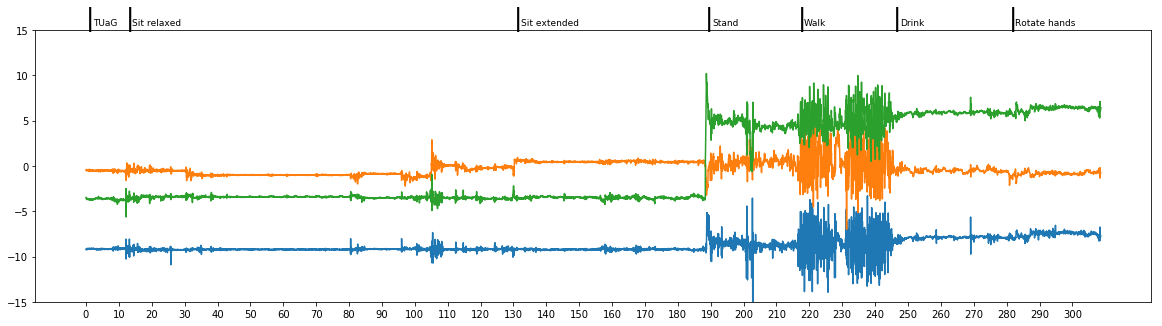



user: 108, assessment: 1488396181636
patient report: 0, clinician report: 2
Norm's mean delta from baseline: 0.11


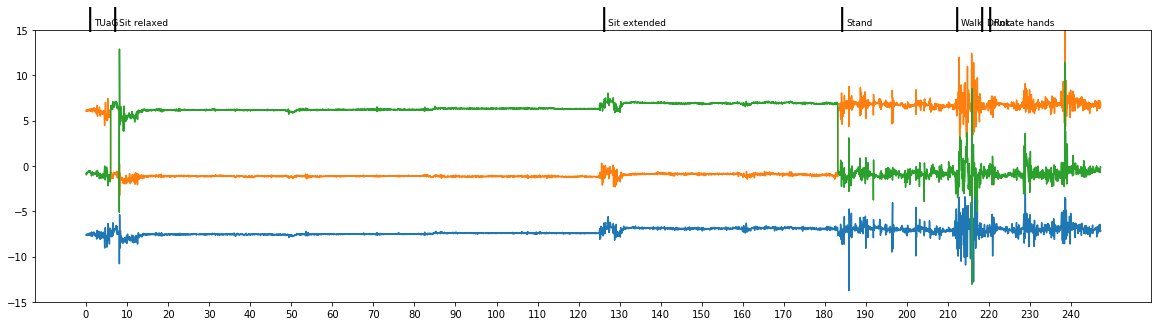



user: 82, assessment: 1489765988342
patient report: 3, clinician report: 4
Norm's mean delta from baseline: 0.32


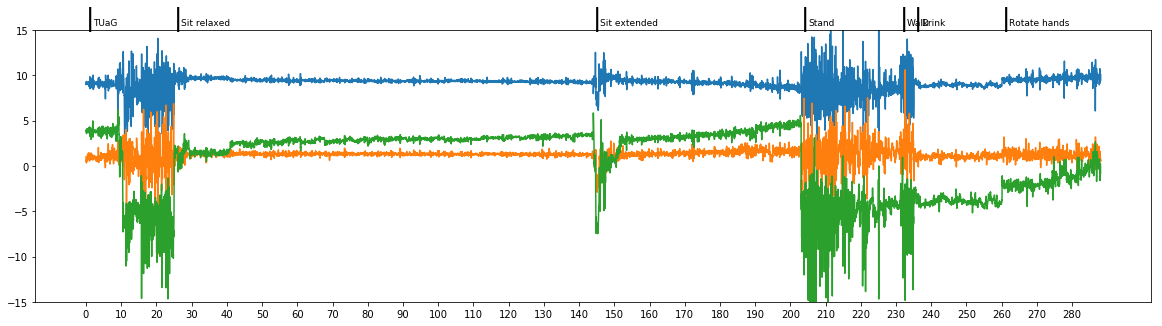



user: 51, assessment: 1490284781631
patient report: 3, clinician report: 2
Norm's mean delta from baseline: 0.26


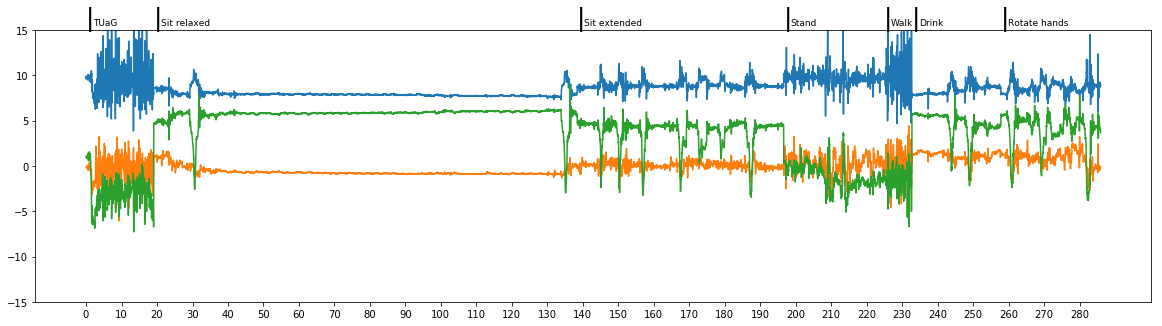



user: 45, assessment: 1490637319938
patient report: 2, clinician report: 3
Norm's mean delta from baseline: 0.54


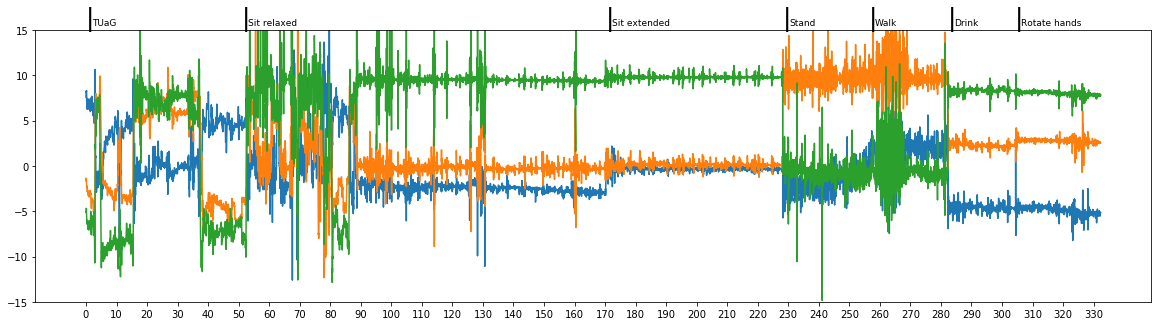



user: 8, assessment: 1490640580656
patient report: 1, clinician report: 2
Norm's mean delta from baseline: 0.16


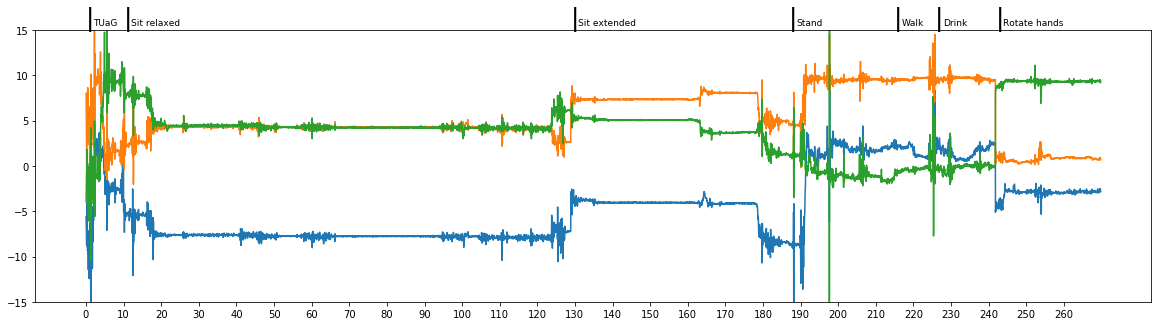



user: 94, assessment: 1493741957038
patient report: 3, clinician report: 2
Norm's mean delta from baseline: 0.14


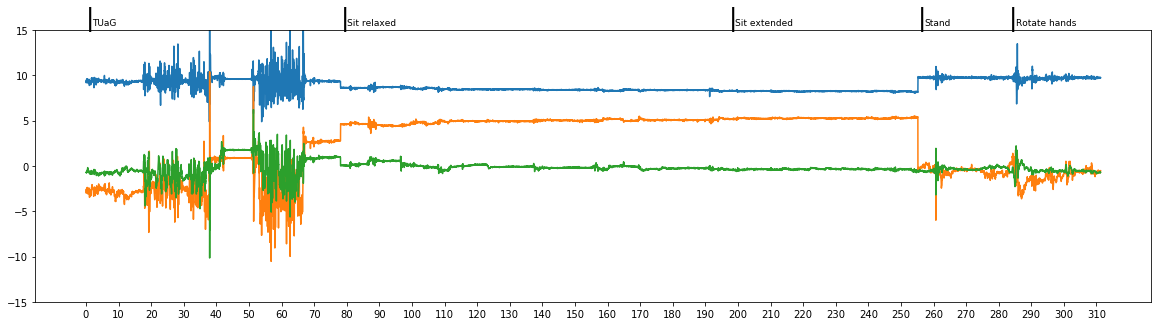



user: 25, assessment: 1493912424448
patient report: 0, clinician report: 2
Norm's mean delta from baseline: 0.20


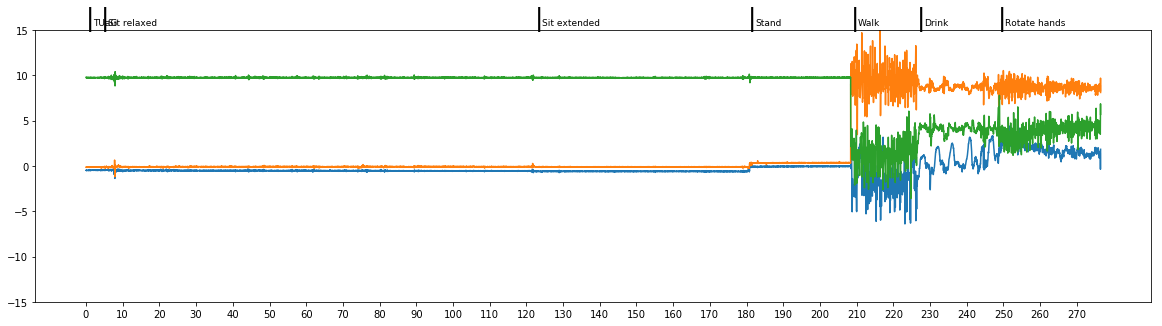



user: 63, assessment: 1493920652116
patient report: 0, clinician report: 2
Norm's mean delta from baseline: 0.20


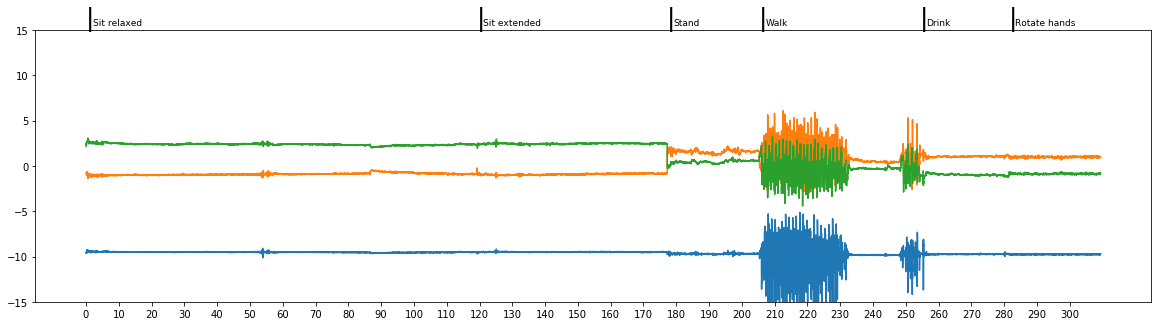

In [64]:
plot_assessment_with_steps(clinic_phone_acc_with_deltas, 'phone')

In [105]:
clinic_phone = clinic_steps_phone_acc_df[['user_id', 'assessment_id', 'step_name', 'patient_report_value', 'clinician_report_value']]\
               .drop_duplicates().sort_values(by=['user_id', 'assessment_id'])

## Home Raw Data Exploration:

In [56]:
all_home_assessments = home_watch_acc_with_deltas['assessment_id'].unique()

In [59]:
random_assessments = np.random.choice(all_home_assessments, 10, replace = False)



user: 57, assessment: 1487729046375
patient report: 2
Norm's mean delta from baseline: 29.16


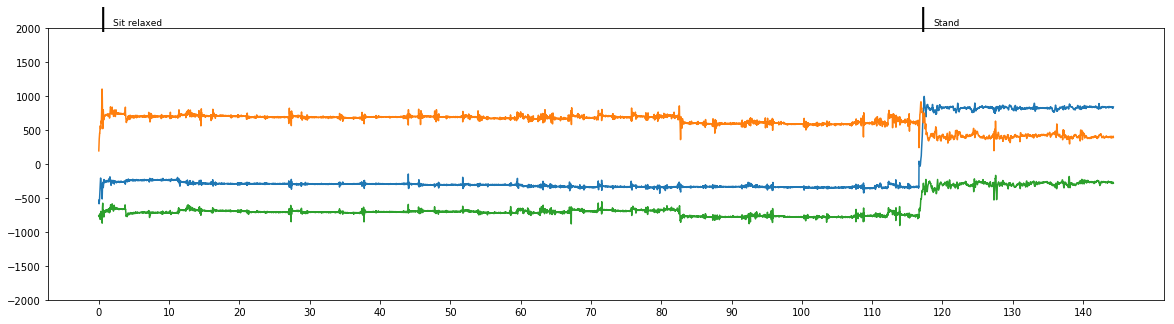



user: 25, assessment: 1488236696945
patient report: 0
Norm's mean delta from baseline: 69.63


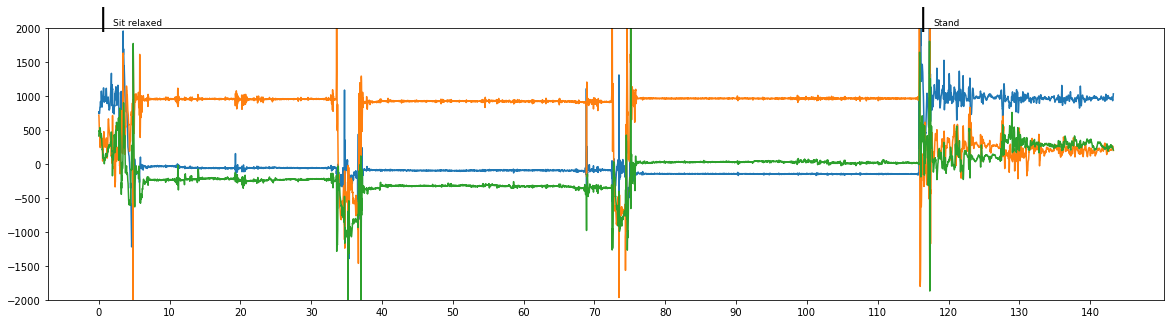



user: 108, assessment: 1488395389306
patient report: 0
Norm's mean delta from baseline: 21.42


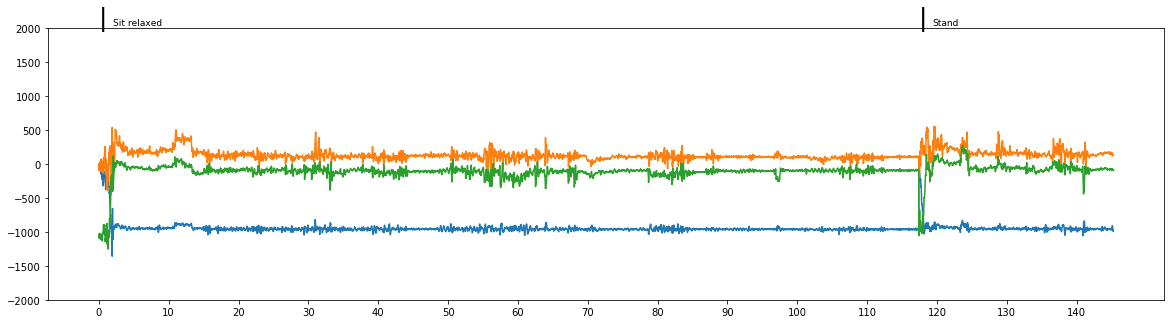



user: 74, assessment: 1489417390556
patient report: 2
Norm's mean delta from baseline: 21.68


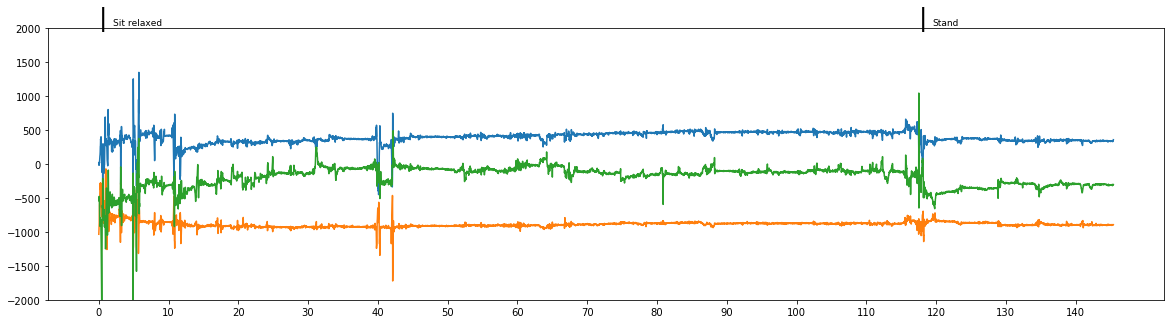



user: 57, assessment: 1490148227403
patient report: 2
Norm's mean delta from baseline: 21.49


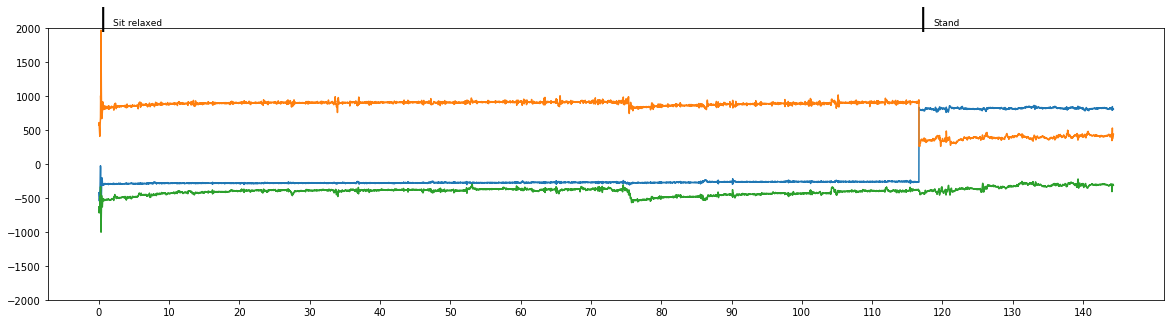



user: 74, assessment: 1493301813273
patient report: 2
Norm's mean delta from baseline: 20.00


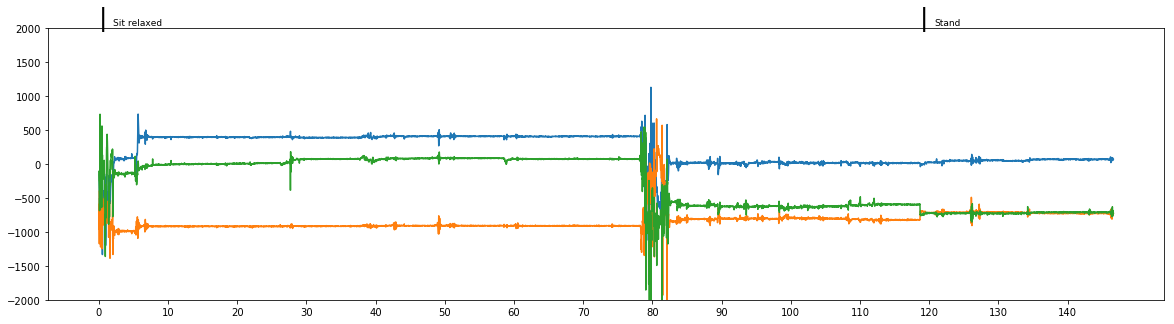



user: 25, assessment: 1493304777885
patient report: 0
Norm's mean delta from baseline: 31.83


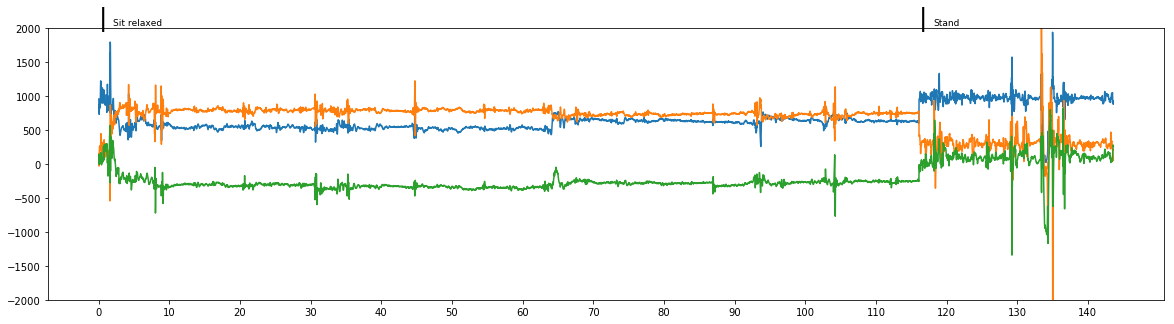



user: 45, assessment: 1494954221705
patient report: 1
Norm's mean delta from baseline: 40.37


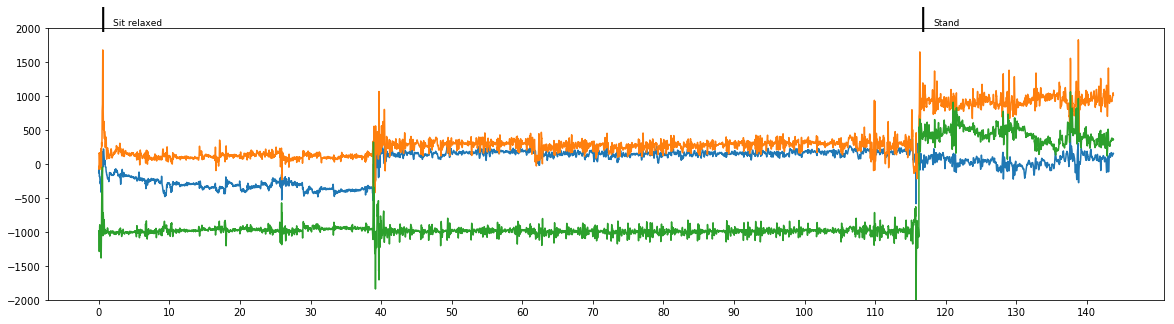



user: 74, assessment: 1495638581360
patient report: 2
Norm's mean delta from baseline: 8.08


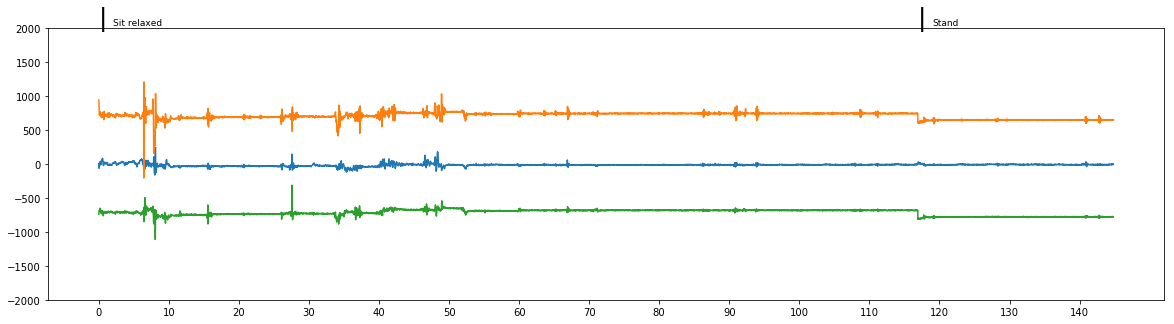



user: 51, assessment: 1496362977841
patient report: 4
Norm's mean delta from baseline: 48.98


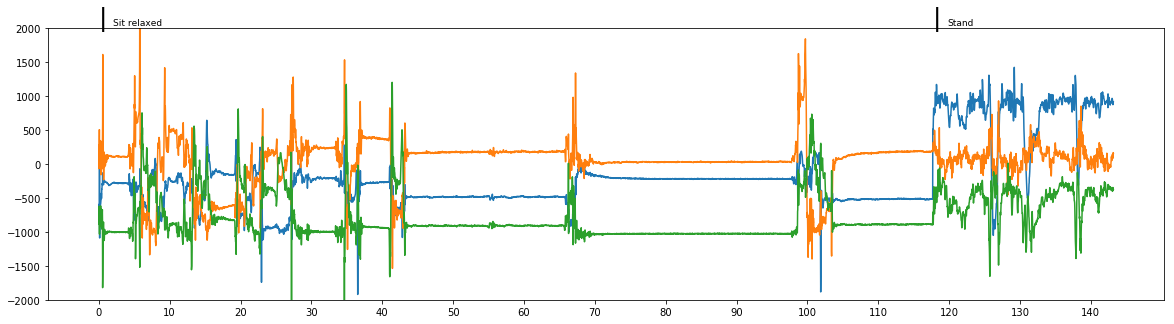

In [65]:
random_watch = home_watch_acc_with_deltas[home_watch_acc_with_deltas['assessment_id'].isin(random_assessments)]
plot_assessment_with_steps(random_watch, 'watch', clinic=False)



user: 57, assessment: 1487729046375
patient report: 2
Norm's mean delta from baseline: 0.13


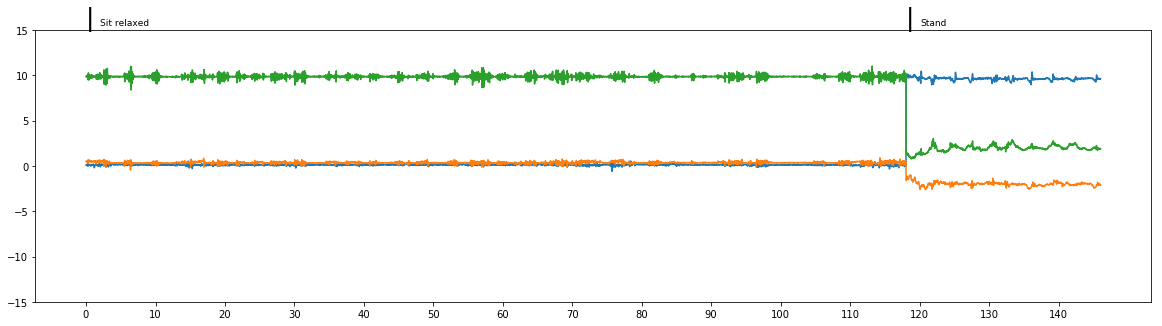



user: 108, assessment: 1488395389306
patient report: 0
Norm's mean delta from baseline: 0.08


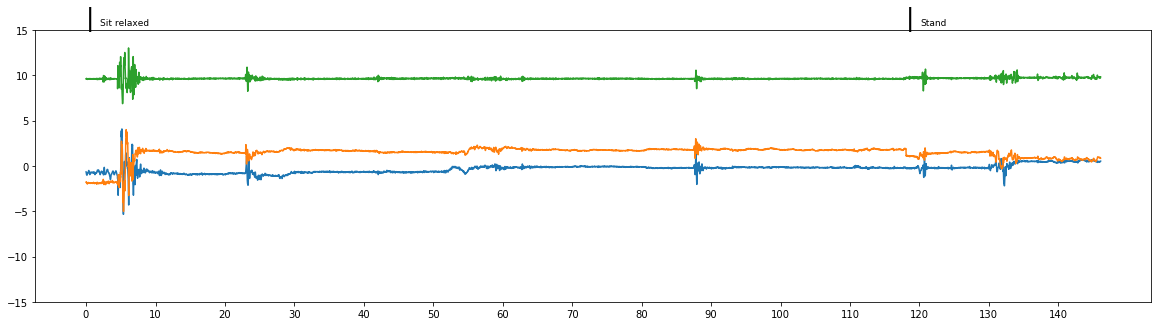



user: 74, assessment: 1489417390556
patient report: 2
Norm's mean delta from baseline: 0.01


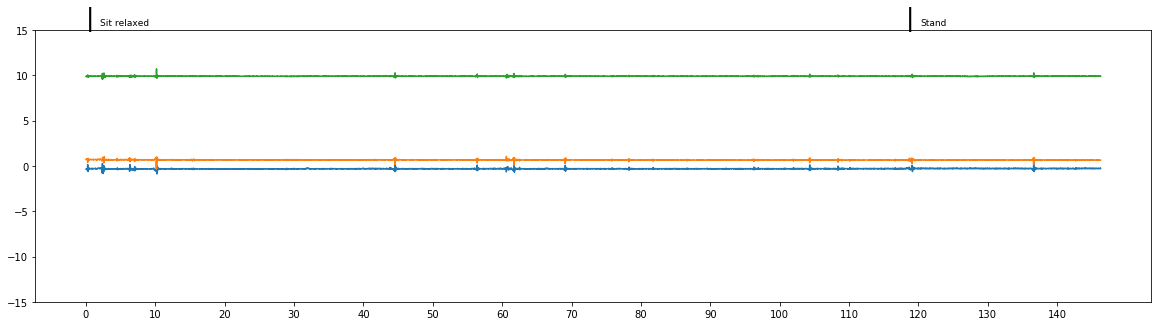



user: 57, assessment: 1490148227403
patient report: 2
Norm's mean delta from baseline: 0.07


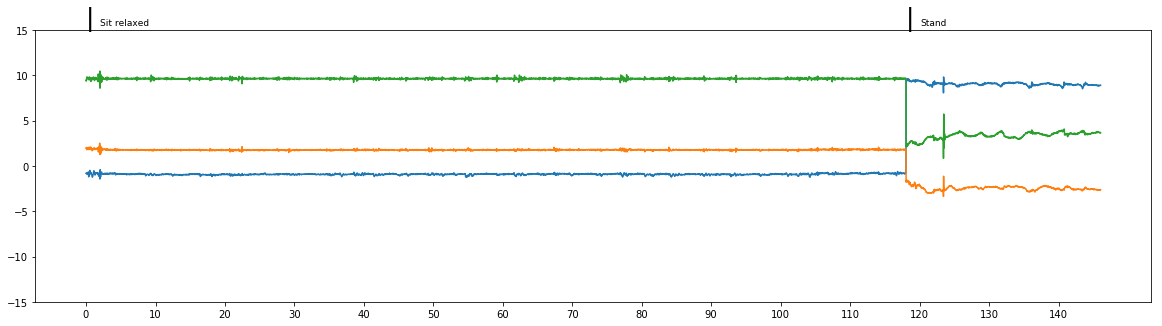



user: 74, assessment: 1493301813273
patient report: 2
Norm's mean delta from baseline: 0.02


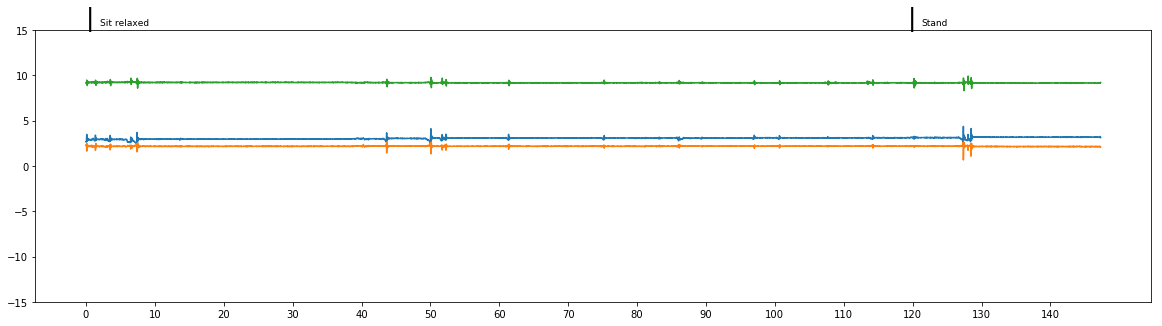



user: 45, assessment: 1494954221705
patient report: 1
Norm's mean delta from baseline: 0.31


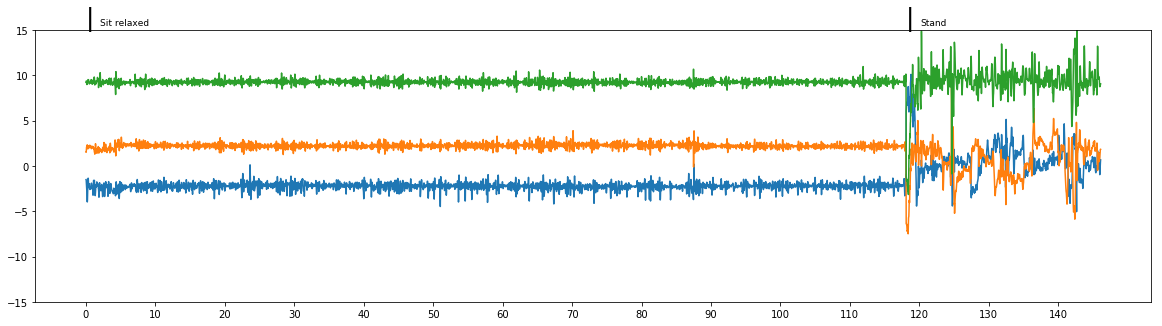



user: 74, assessment: 1495638581360
patient report: 2
Norm's mean delta from baseline: 0.03


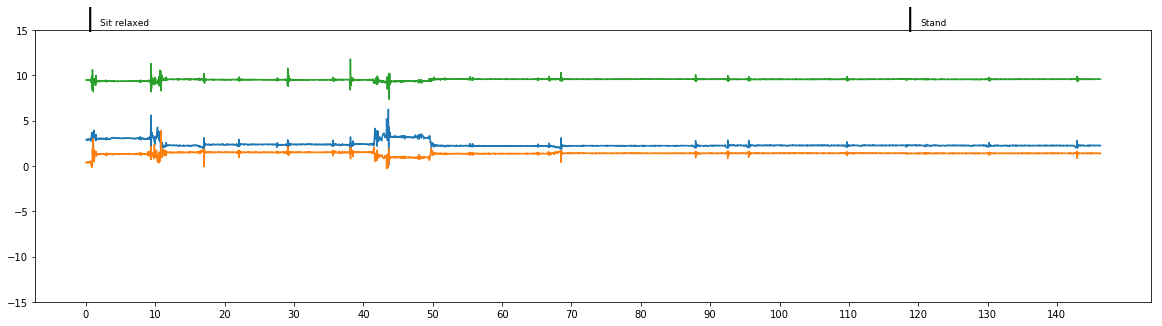



user: 51, assessment: 1496362977841
patient report: 4
Norm's mean delta from baseline: 0.02


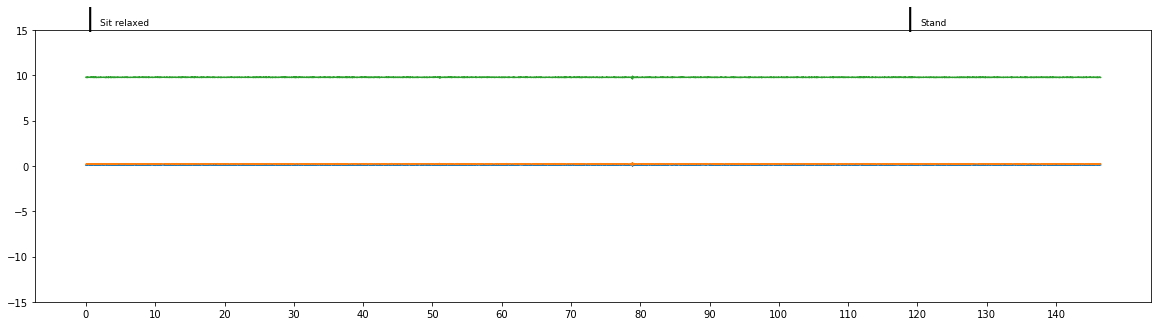

In [67]:
random_phone = home_phone_acc_with_deltas[home_phone_acc_with_deltas['assessment_id'].isin(random_assessments)]
plot_assessment_with_steps(random_phone, 'phone', clinic=False)

## Drill-downs:

In [103]:
home_phone_assessments_45 = home_phone_acc_with_deltas[home_phone_acc_with_deltas['user_id']==45]

In [104]:
home_phone_assessments_45.patient_report_value.unique()

array([ 0.,  1.,  2.])

C:\Users\imazeh\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\stats\stats.py:2958: RuntimeWarning: invalid value encountered in double_scalars
  ssbn += _square_of_sums(a - offset) / float(len(a))


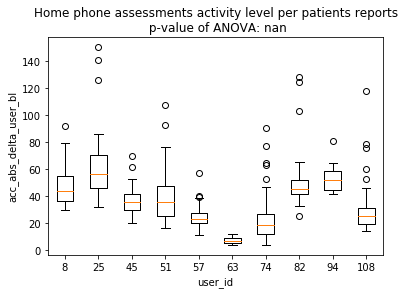

In [108]:
home_watch_acc_per_assess_al = home_watch_acc_with_deltas[['user_id', 'assessment_id', 
                                                             'acc_abs_delta_user_bl']].\
                               groupby(['user_id', 'assessment_id'], as_index=False).agg('mean')

boxes_vals = [np.asarray(home_phone_acc_per_assess_al['acc_abs_delta_user_bl']\
              [home_watch_acc_per_assess_al['user_id'] == x]) for x in home_watch_acc_per_assess_al['user_id'].unique()]
f, p = stats.f_oneway(boxes_vals[0], boxes_vals[1], boxes_vals[2], boxes_vals[3], boxes_vals[4], boxes_vals[5], boxes_vals[6],
                      boxes_vals[7], boxes_vals[8], boxes_vals[9],)
box_plot.create_box_plot(home_watch_acc_per_assess_al, x_discrete_variable='user_id',
                         y_cont_variable='acc_abs_delta_user_bl', all_possible_x_vals=None,
                         plt_title='Home phone assessments activity level per patients reports\n p-value of ANOVA: %.3f' % (p))



user: 45, assessment: 1490635494345
patient report: 2
Norm's mean delta from baseline: 33.51


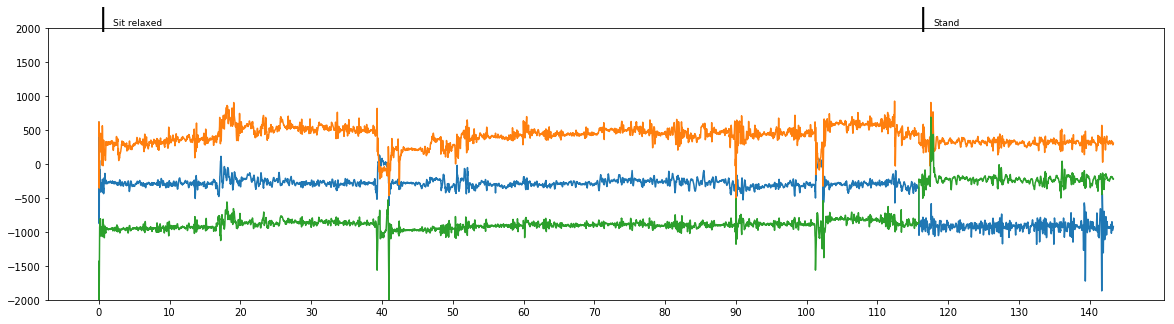



user: 45, assessment: 1490652176969
patient report: 0
Norm's mean delta from baseline: 21.38


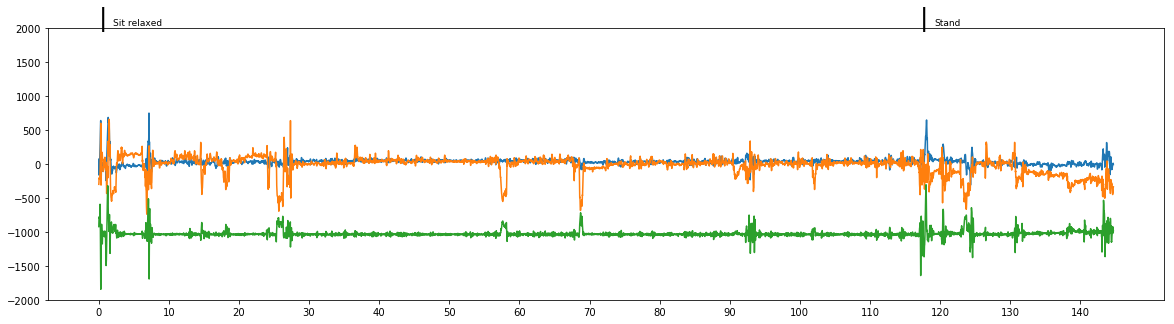



user: 45, assessment: 1491063880675
patient report: 1
Norm's mean delta from baseline: 28.89


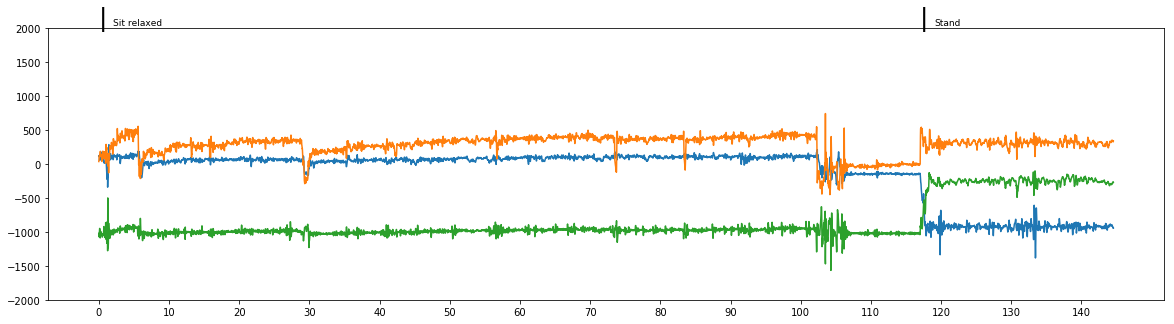



user: 45, assessment: 1491239273207
patient report: 1
Norm's mean delta from baseline: 29.15


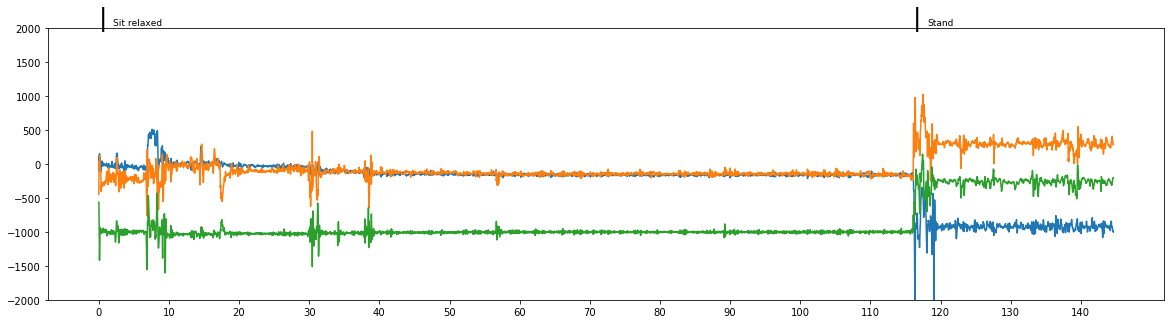



user: 45, assessment: 1491584838669
patient report: 0
Norm's mean delta from baseline: 28.43


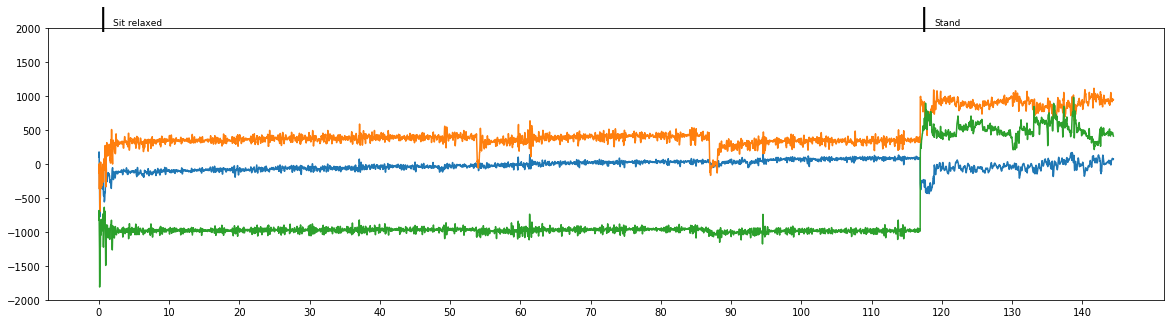



user: 45, assessment: 1491855210024
patient report: 1
Norm's mean delta from baseline: 33.08


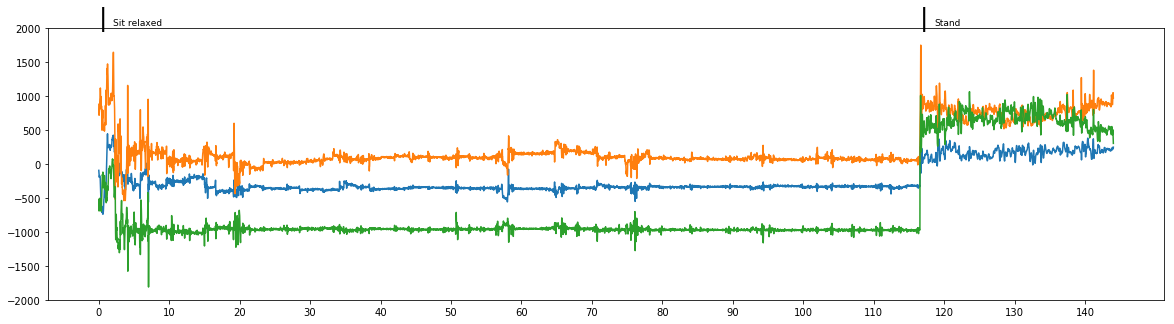



user: 45, assessment: 1491959396396
patient report: 1
Norm's mean delta from baseline: 42.90


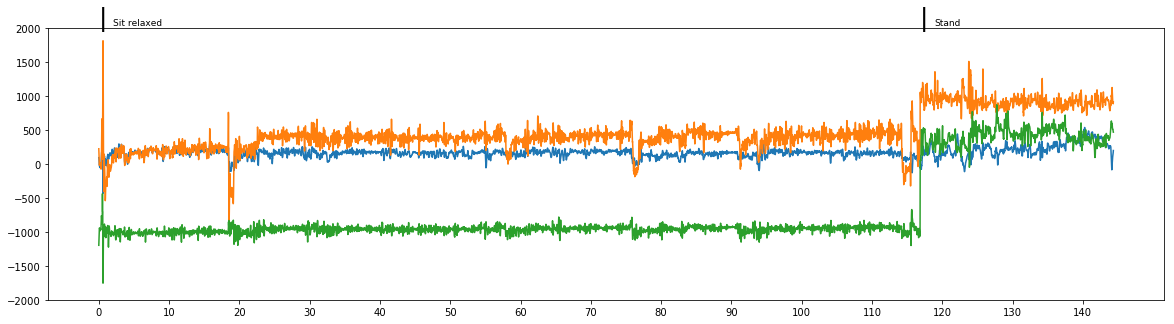



user: 45, assessment: 1492100249204
patient report: 0
Norm's mean delta from baseline: 40.85


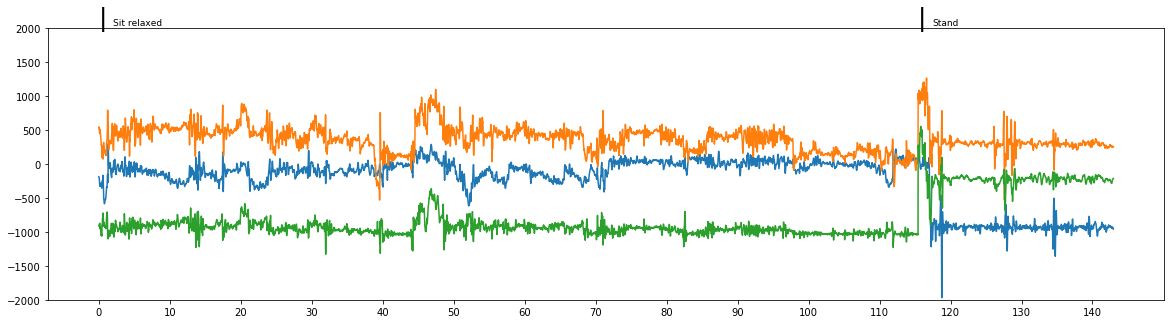



user: 45, assessment: 1492189401095
patient report: 1
Norm's mean delta from baseline: 28.81


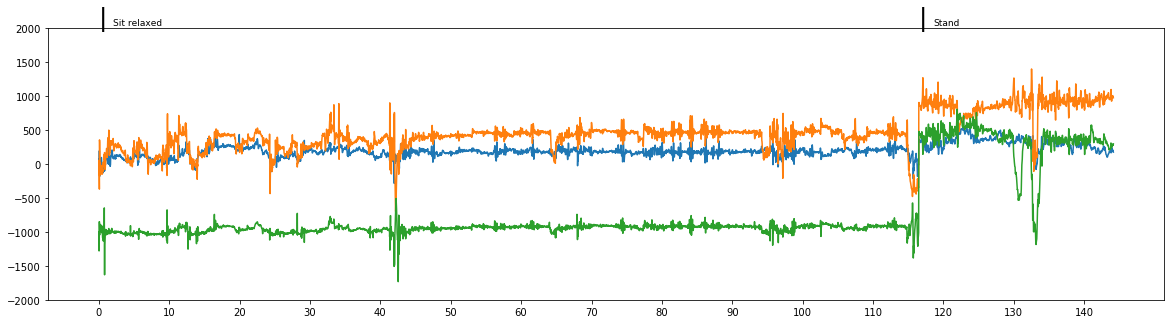



user: 45, assessment: 1492290015786
patient report: 1
Norm's mean delta from baseline: 41.16


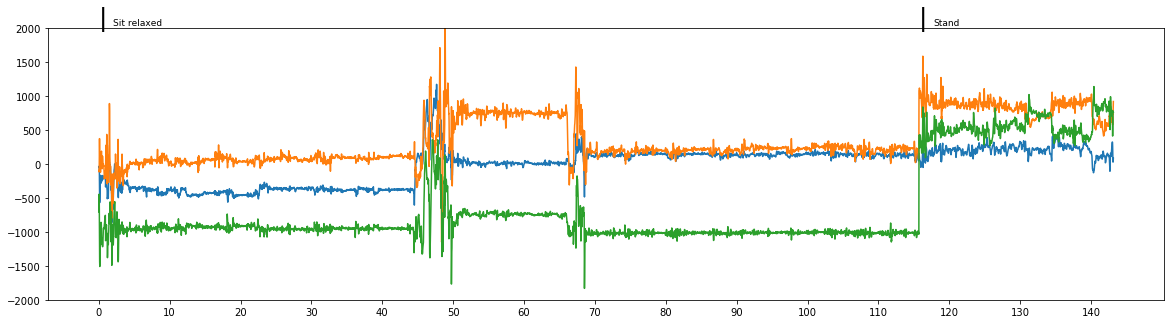



user: 45, assessment: 1492448006620
patient report: 1
Norm's mean delta from baseline: 26.61


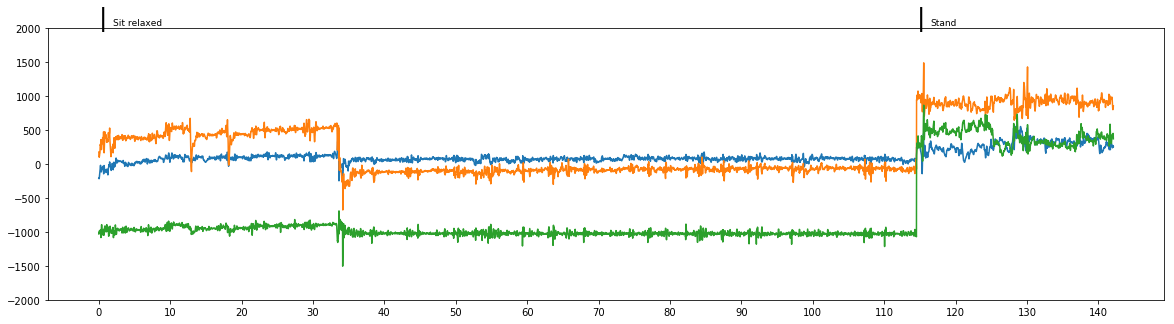



user: 45, assessment: 1492541254791
patient report: 1
Norm's mean delta from baseline: 31.83


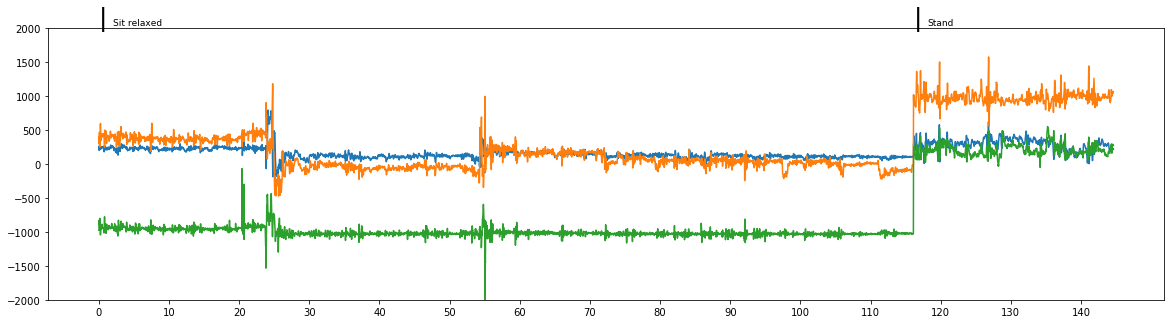



user: 45, assessment: 1492631581595
patient report: 1
Norm's mean delta from baseline: 32.68


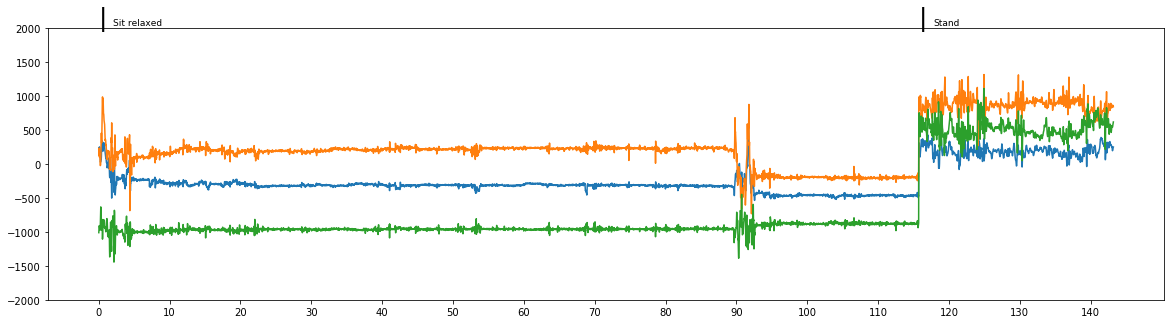



user: 45, assessment: 1492709251337
patient report: 1
Norm's mean delta from baseline: 19.57


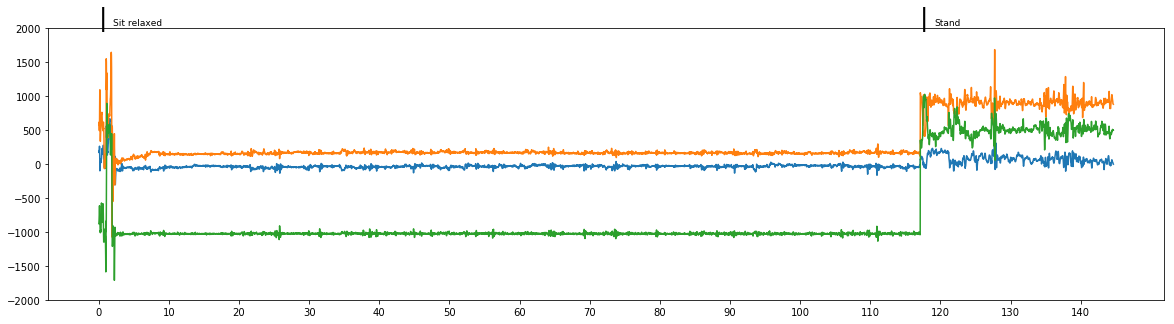



user: 45, assessment: 1492790756356
patient report: 0
Norm's mean delta from baseline: 44.78


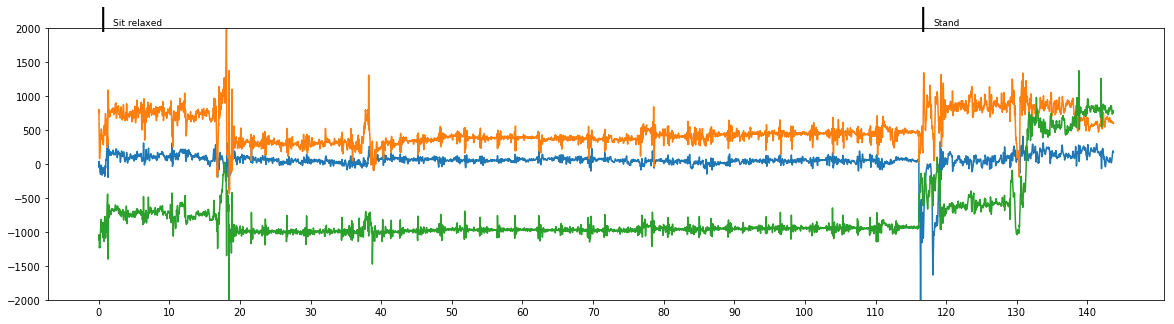



user: 45, assessment: 1492880596088
patient report: 1
Norm's mean delta from baseline: 41.80


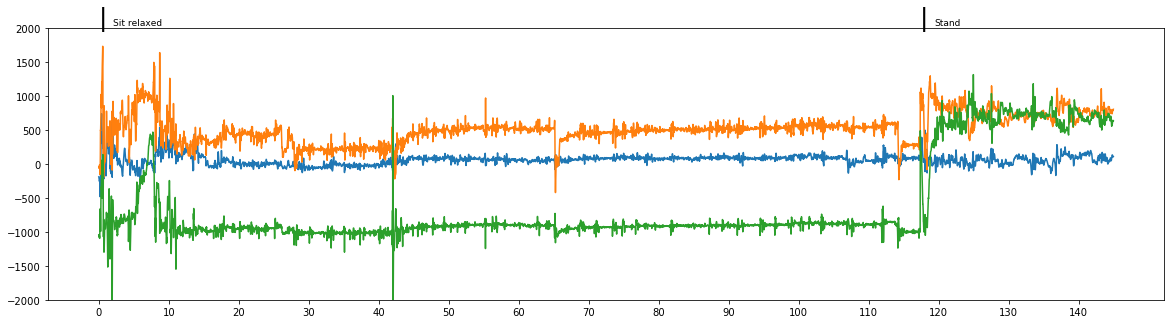



user: 45, assessment: 1492973342569
patient report: 1
Norm's mean delta from baseline: 37.76


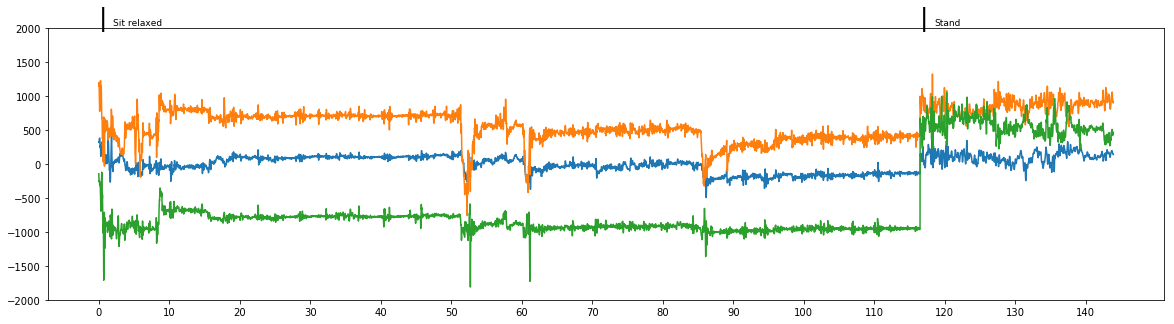



user: 45, assessment: 1493053447761
patient report: 1
Norm's mean delta from baseline: 38.84


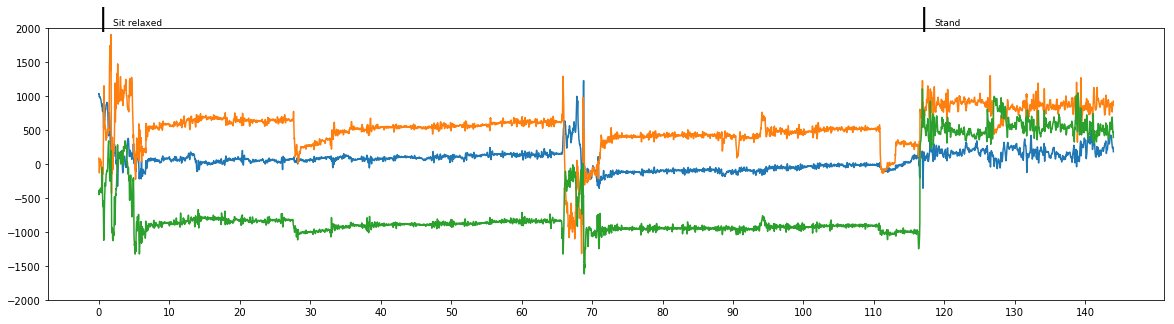



user: 45, assessment: 1493136130810
patient report: 0
Norm's mean delta from baseline: 43.68


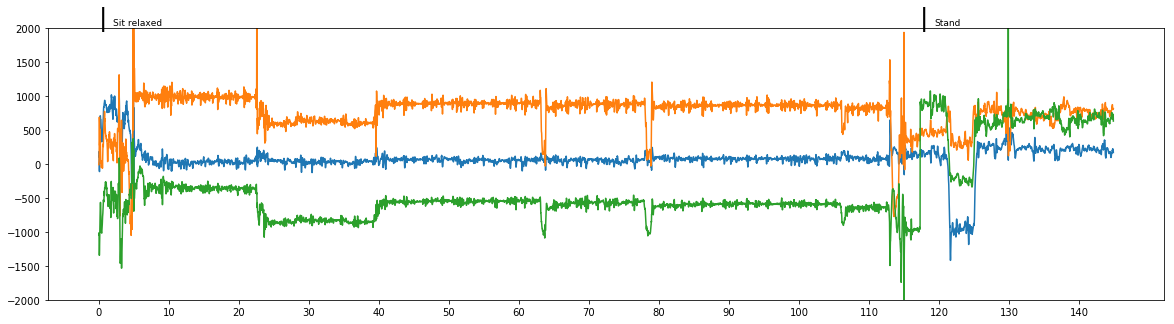



user: 45, assessment: 1493226648393
patient report: 1
Norm's mean delta from baseline: 26.53


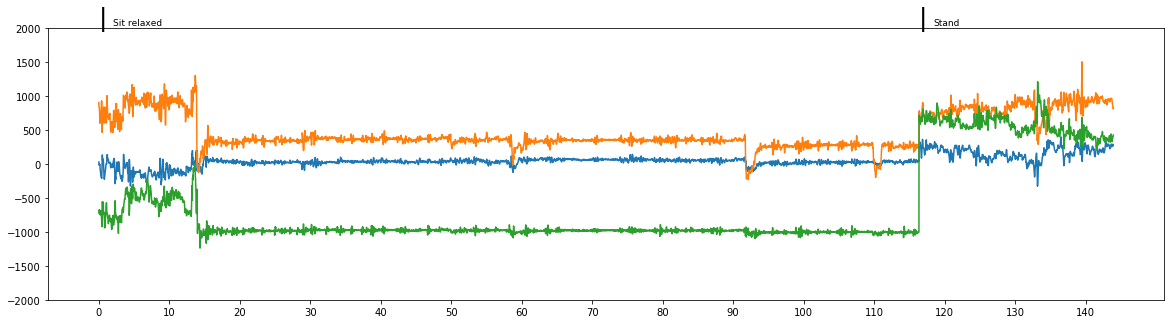



user: 45, assessment: 1493312835928
patient report: 1
Norm's mean delta from baseline: 33.21


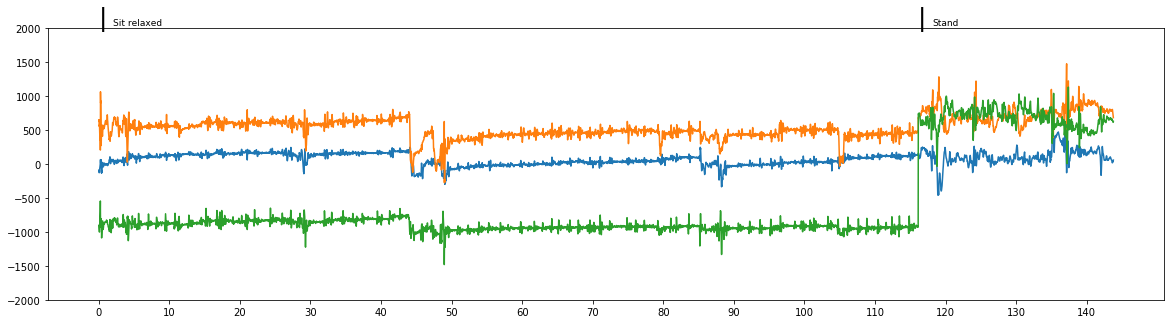



user: 45, assessment: 1493398987063
patient report: 0
Norm's mean delta from baseline: 43.36


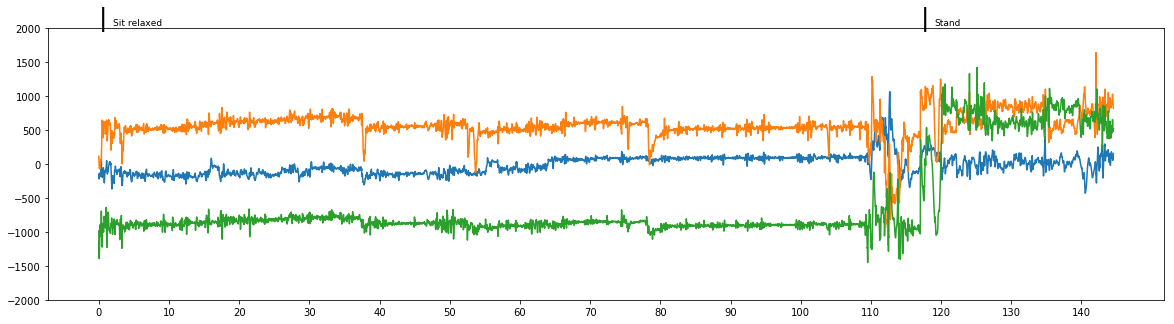



user: 45, assessment: 1493481727483
patient report: 1
Norm's mean delta from baseline: 40.00


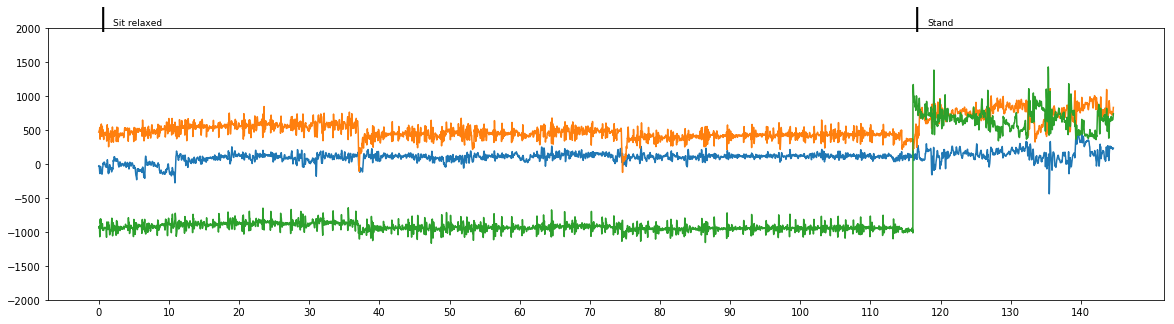



user: 45, assessment: 1493578312136
patient report: 1
Norm's mean delta from baseline: 41.20


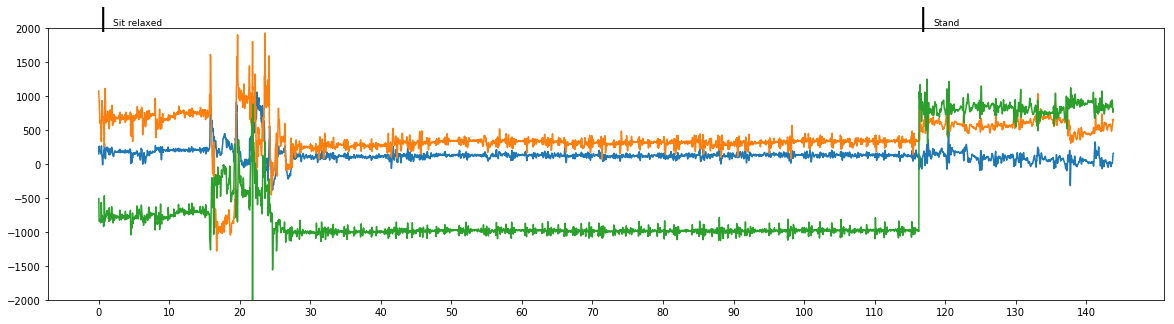



user: 45, assessment: 1493658209582
patient report: 2
Norm's mean delta from baseline: 31.83


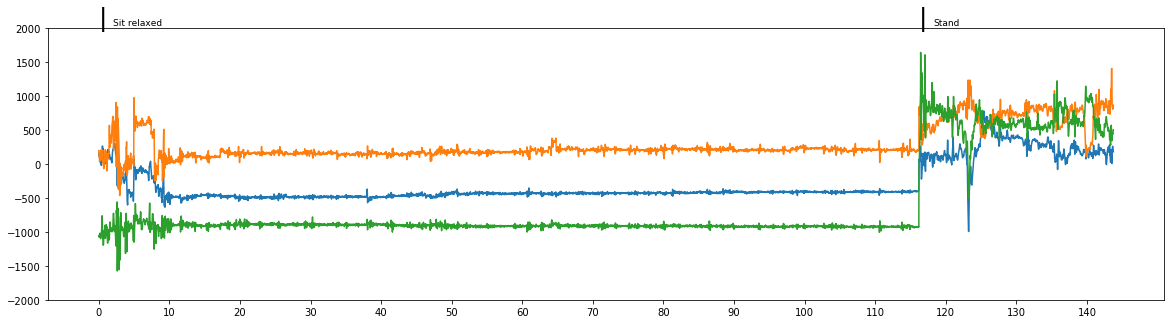



user: 45, assessment: 1493745030518
patient report: 0
Norm's mean delta from baseline: 35.46


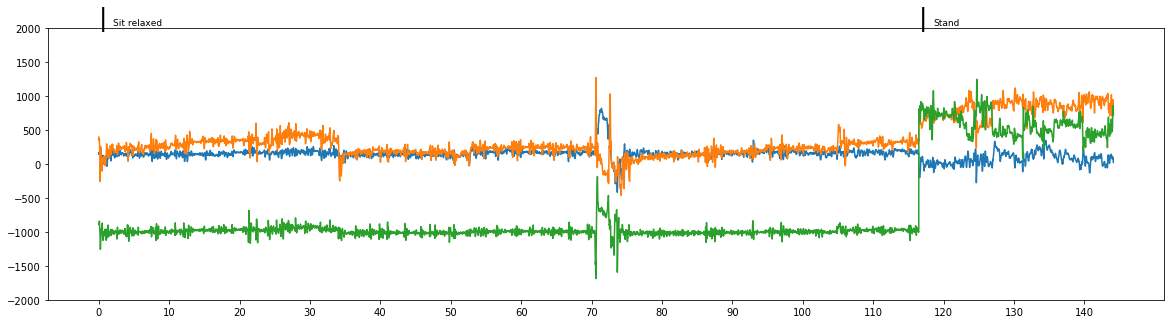



user: 45, assessment: 1493827625363
patient report: 1
Norm's mean delta from baseline: 42.05


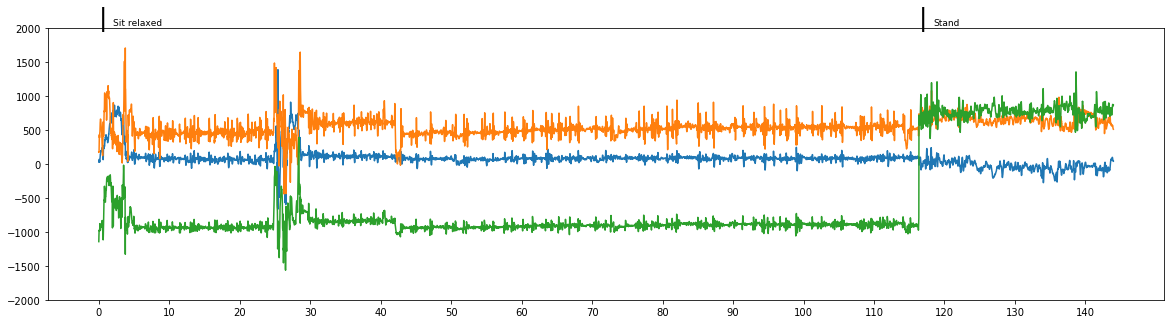



user: 45, assessment: 1493925232182
patient report: 1
Norm's mean delta from baseline: 27.92


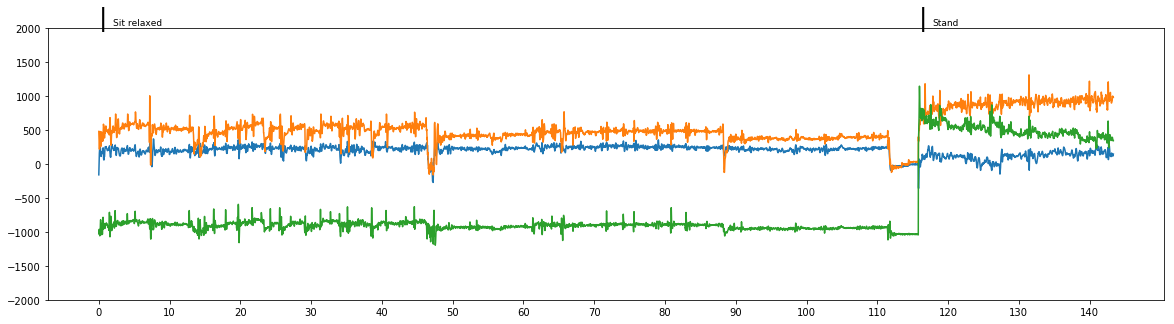



user: 45, assessment: 1494011937650
patient report: 0
Norm's mean delta from baseline: 27.20


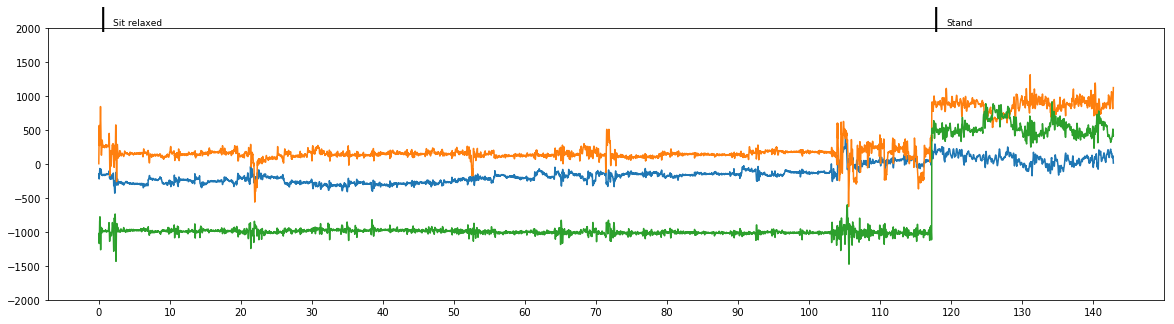



user: 45, assessment: 1494090000465
patient report: 1
Norm's mean delta from baseline: 36.23


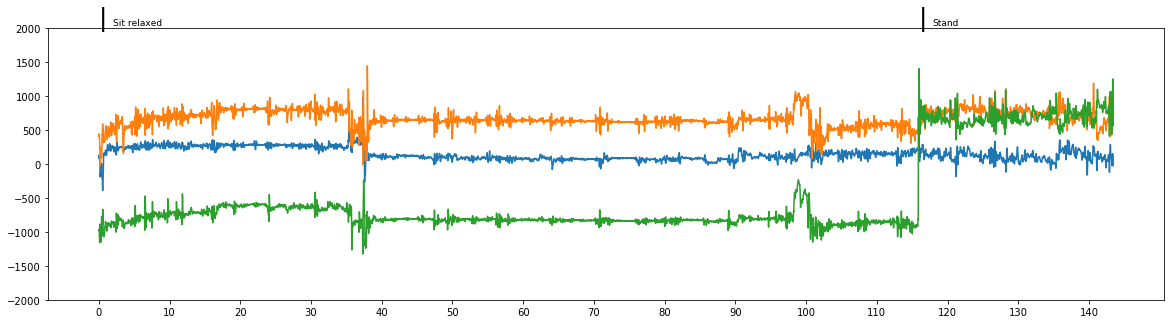



user: 45, assessment: 1494172923126
patient report: 1
Norm's mean delta from baseline: 34.31


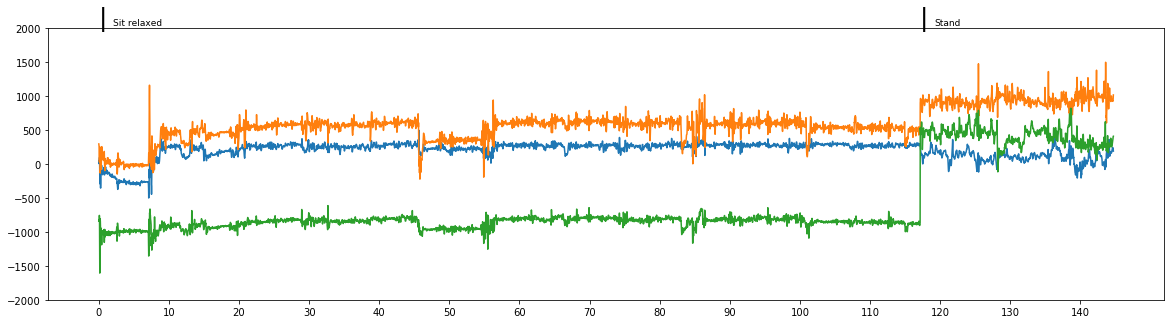



user: 45, assessment: 1494267347364
patient report: 1
Norm's mean delta from baseline: 23.89


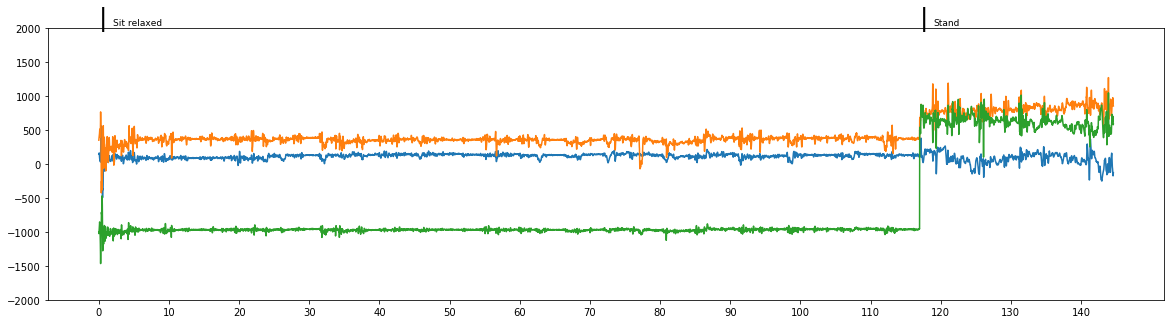



user: 45, assessment: 1494358141142
patient report: 1
Norm's mean delta from baseline: 39.78


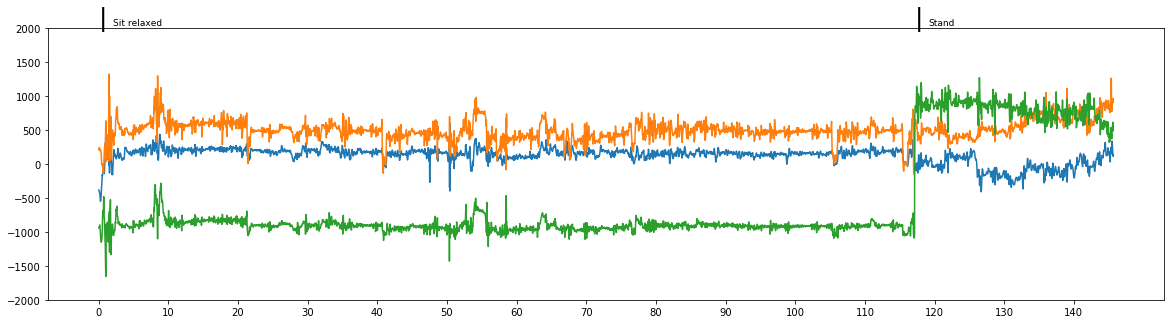



user: 45, assessment: 1494443774116
patient report: 1
Norm's mean delta from baseline: 36.12


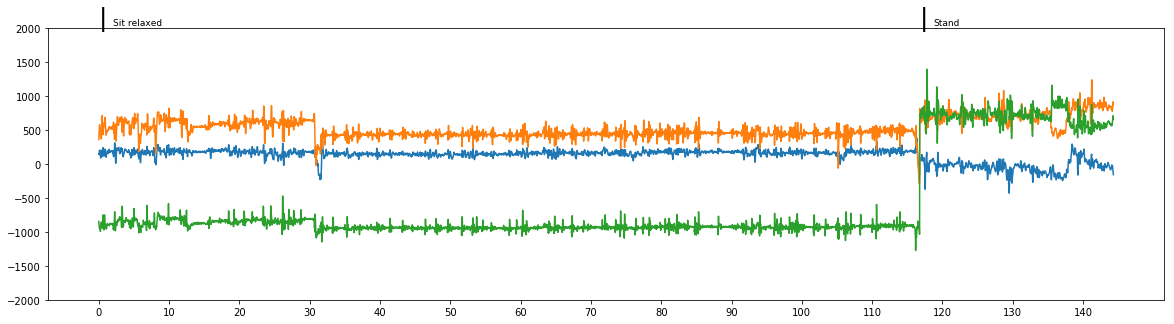



user: 45, assessment: 1494518562872
patient report: 1
Norm's mean delta from baseline: 29.83


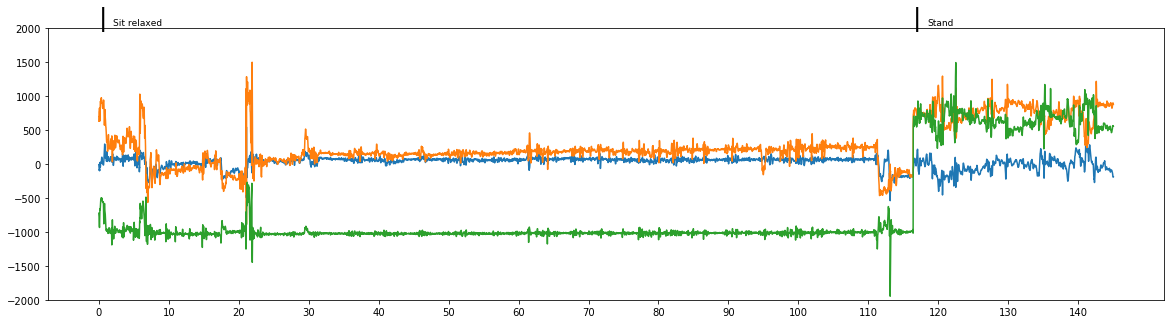



user: 45, assessment: 1494695027150
patient report: 1
Norm's mean delta from baseline: 35.22


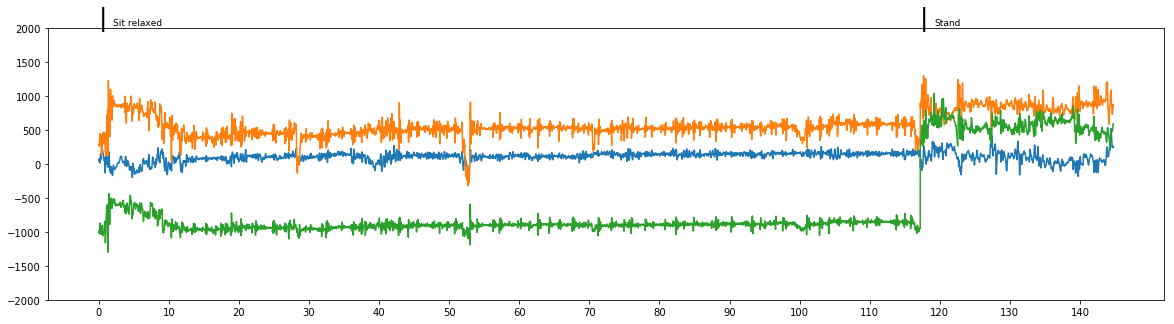



user: 45, assessment: 1494781411184
patient report: 1
Norm's mean delta from baseline: 61.12


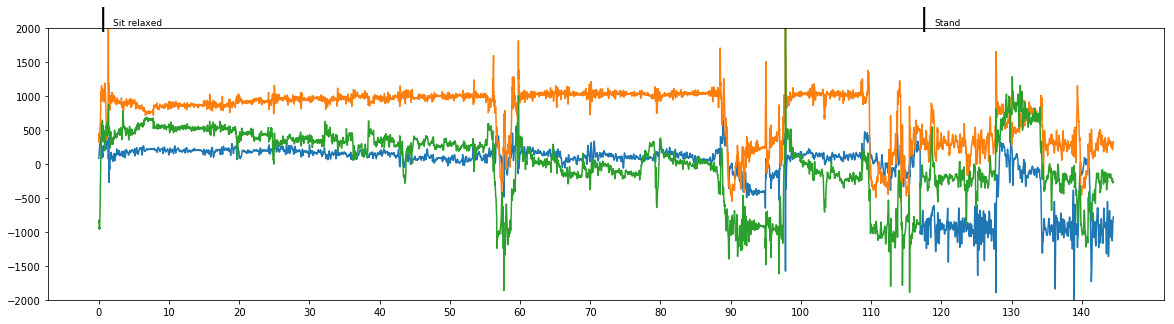



user: 45, assessment: 1494865507548
patient report: 1
Norm's mean delta from baseline: 31.87


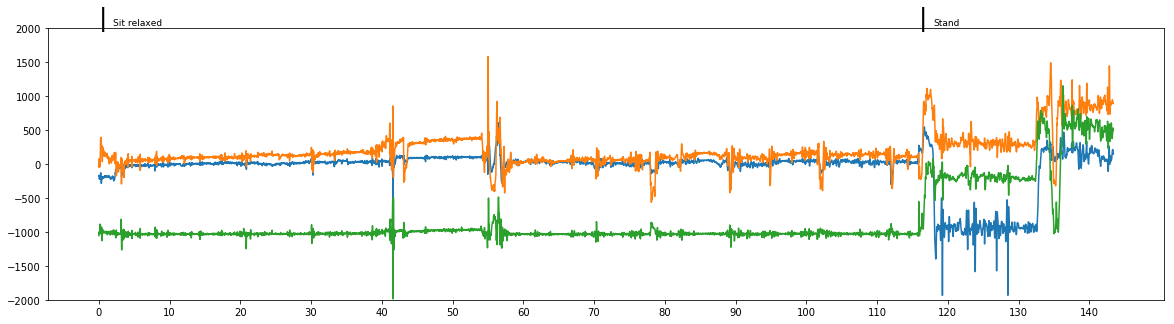



user: 45, assessment: 1494954221705
patient report: 1
Norm's mean delta from baseline: 40.37


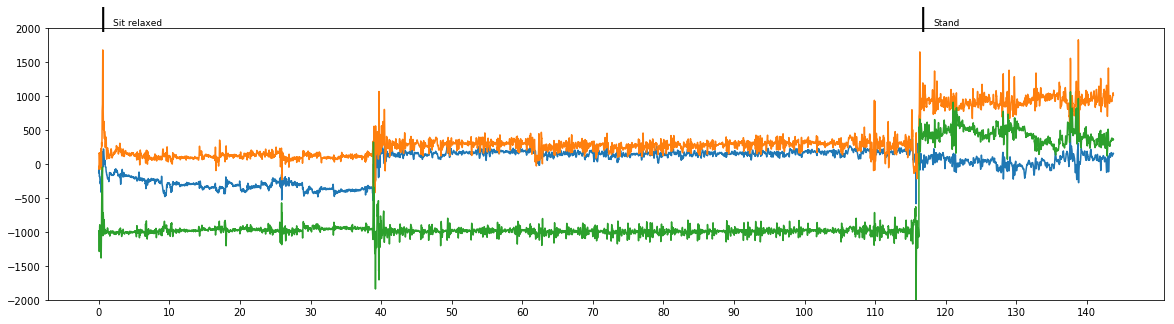



user: 45, assessment: 1495050654176
patient report: 0
Norm's mean delta from baseline: 52.29


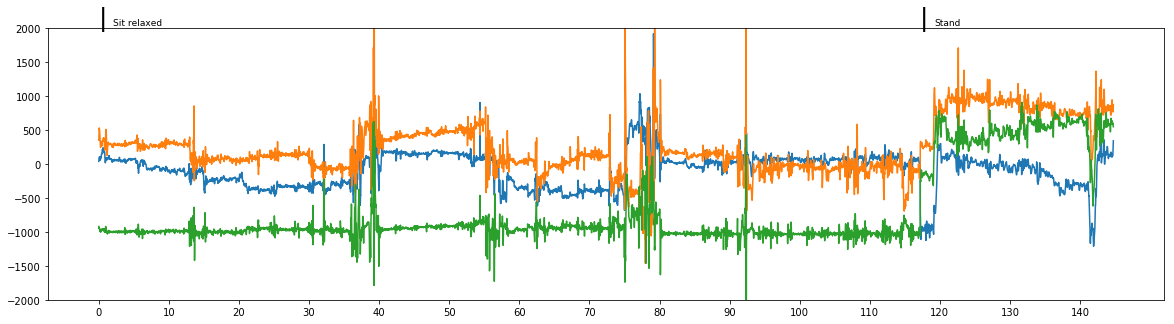



user: 45, assessment: 1495133857192
patient report: 1
Norm's mean delta from baseline: 29.17


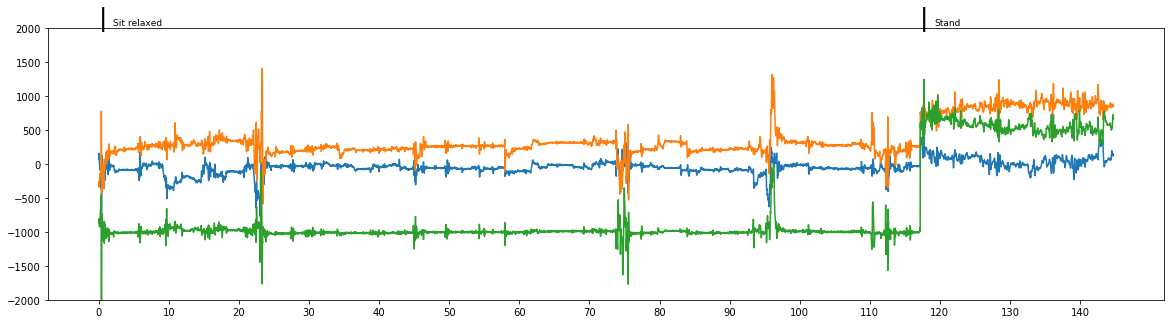



user: 45, assessment: 1495221426231
patient report: 1
Norm's mean delta from baseline: 44.12


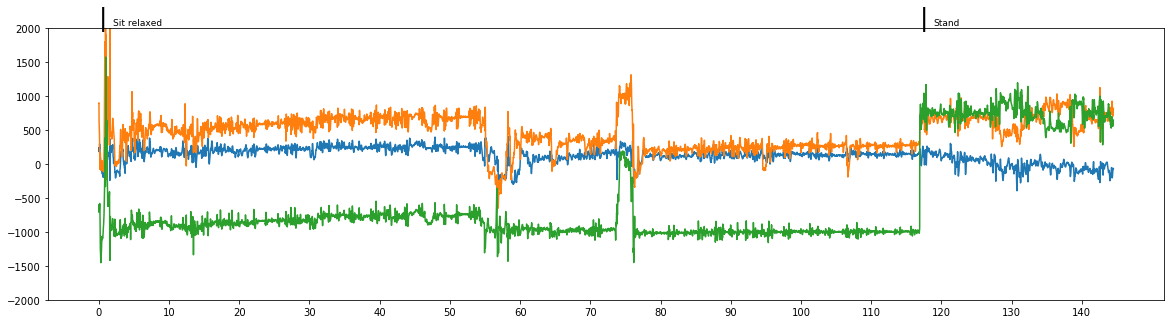



user: 45, assessment: 1495300994698
patient report: 0
Norm's mean delta from baseline: 34.46


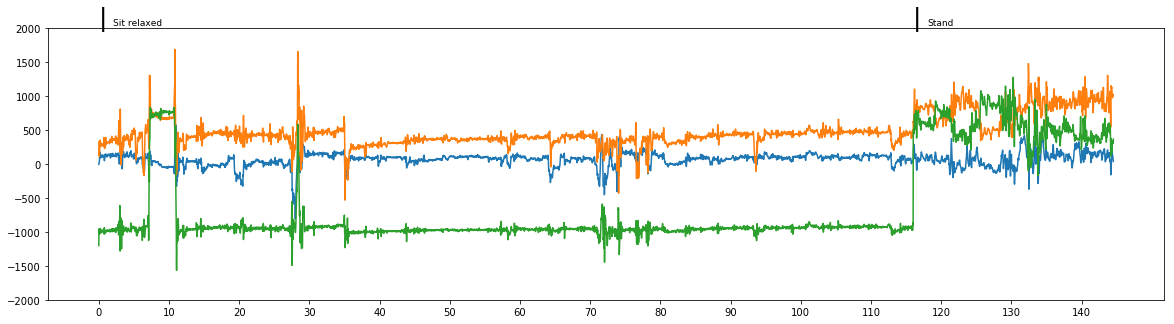



user: 45, assessment: 1495386659115
patient report: 1
Norm's mean delta from baseline: 28.42


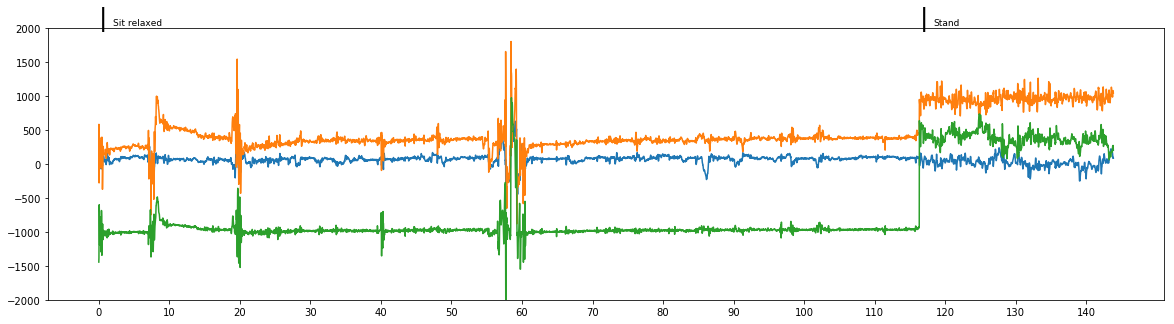



user: 45, assessment: 1495481076757
patient report: 1
Norm's mean delta from baseline: 47.42


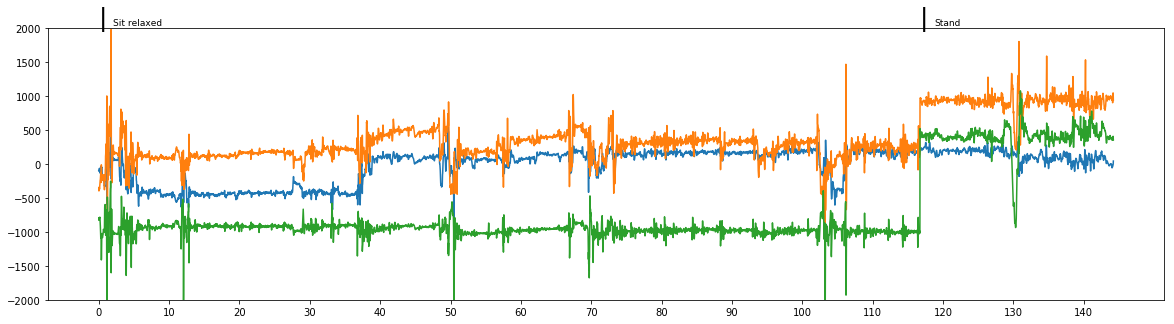



user: 45, assessment: 1495558988925
patient report: 1
Norm's mean delta from baseline: 37.50


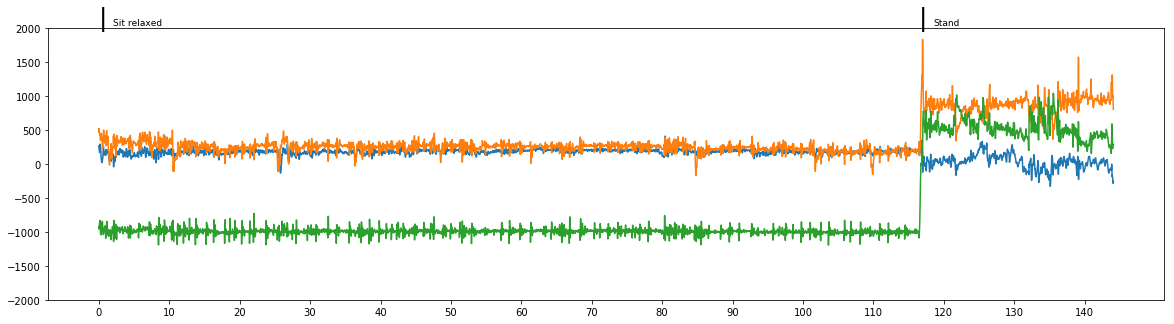



user: 45, assessment: 1495656426937
patient report: 1
Norm's mean delta from baseline: 25.77


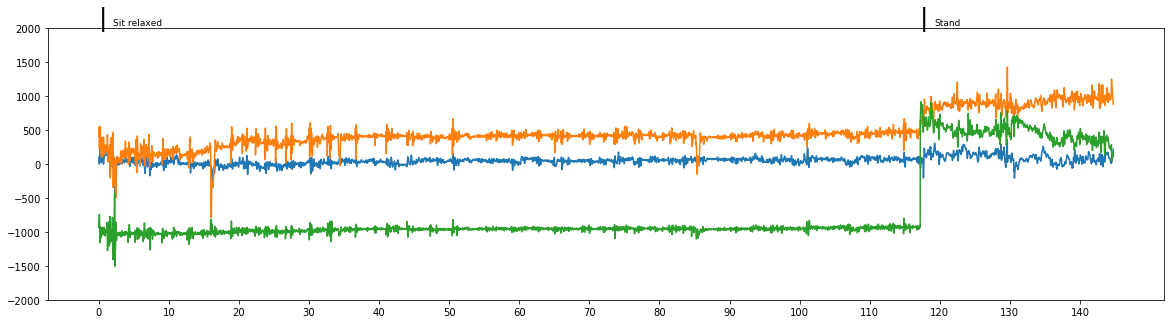



user: 45, assessment: 1495743317038
patient report: 1
Norm's mean delta from baseline: 39.38


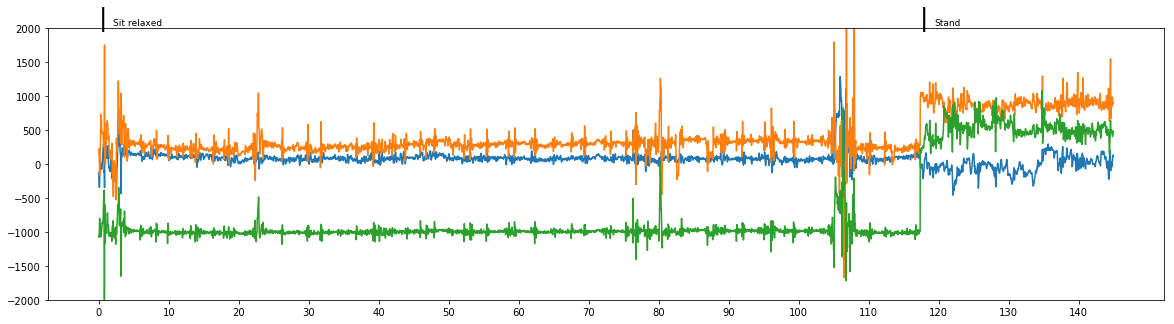



user: 45, assessment: 1495824522375
patient report: 0
Norm's mean delta from baseline: 35.09


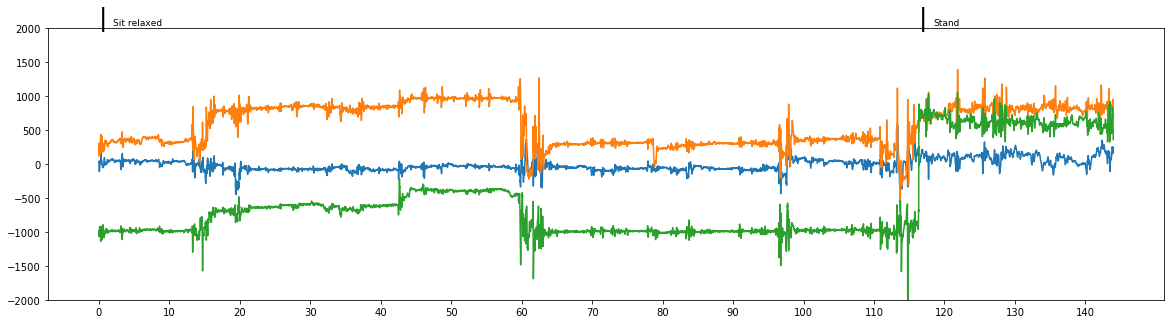



user: 45, assessment: 1495911557737
patient report: 1
Norm's mean delta from baseline: 36.42


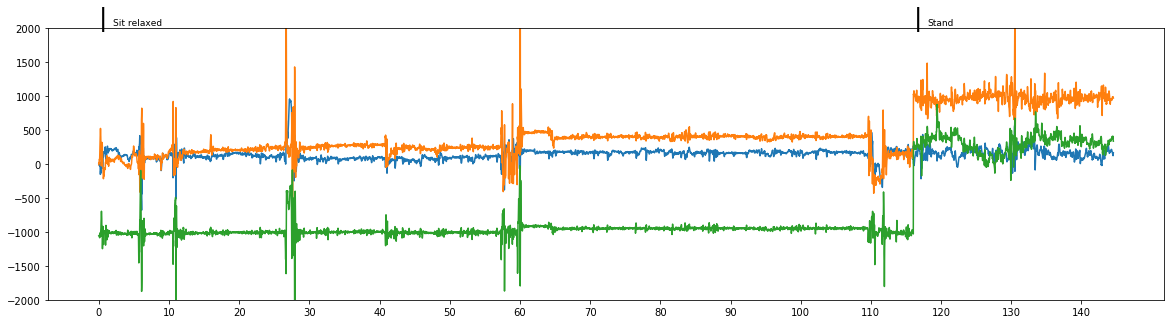



user: 45, assessment: 1495991824597
patient report: 1
Norm's mean delta from baseline: 46.09


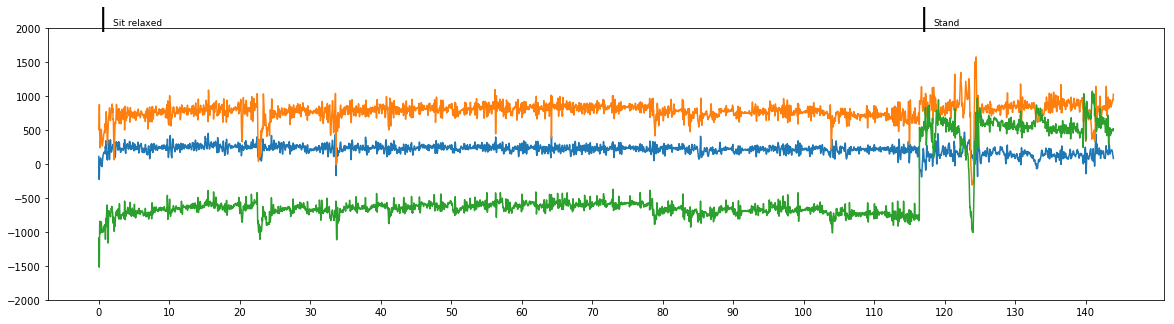



user: 45, assessment: 1496080563523
patient report: 1
Norm's mean delta from baseline: 69.76


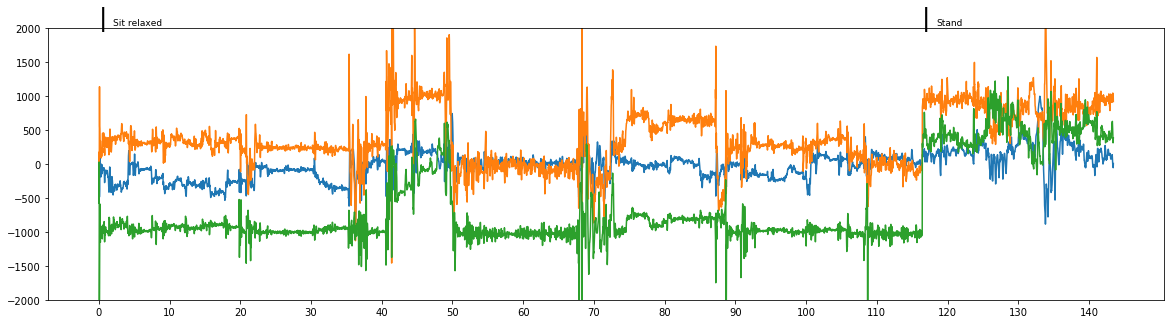



user: 45, assessment: 1496177773041
patient report: 1
Norm's mean delta from baseline: 47.19


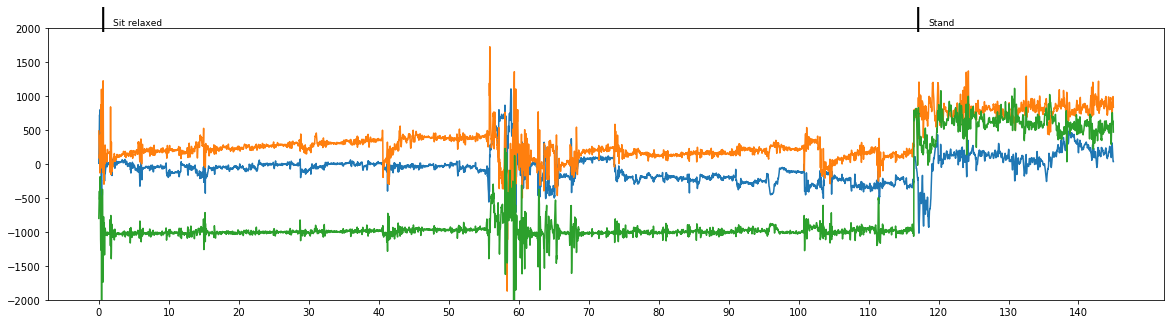



user: 45, assessment: 1496259048438
patient report: 1
Norm's mean delta from baseline: 40.14


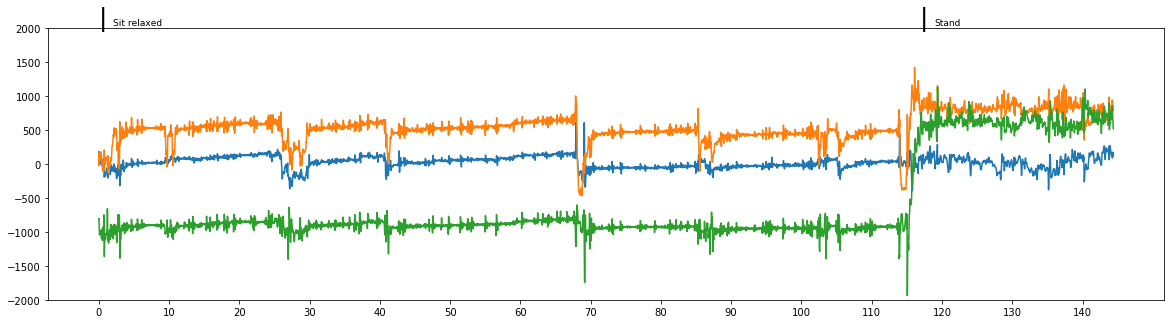



user: 45, assessment: 1496344372152
patient report: 1
Norm's mean delta from baseline: 32.99


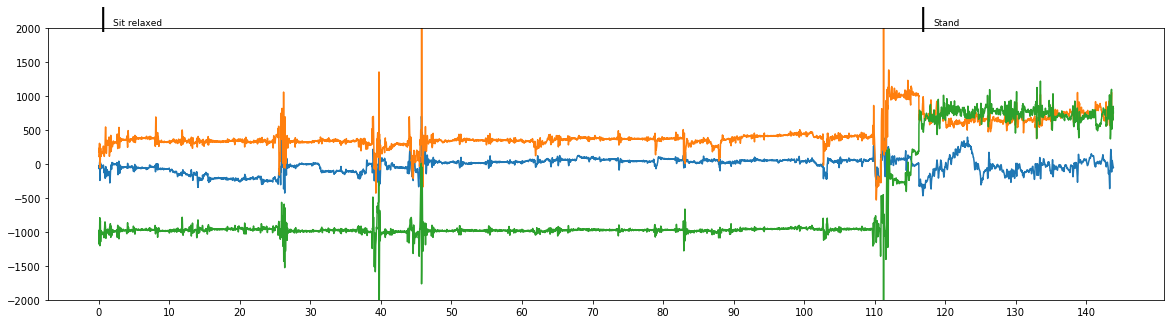



user: 45, assessment: 1496429842437
patient report: 1
Norm's mean delta from baseline: 31.03


In [102]:
plot_assessment_with_steps(home_watch_assessments_45, 'watch', clinic=False)